Описание задачи:
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
В рамках проекта нужно решить две задачи. 
Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
Теперь расскажем подробнее о задачах.

In [1]:
!pip install phik
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,FunctionTransformer,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor
import os
from sklearn.dummy import DummyClassifier


## Первая задача

## 1. Загрузка данных

In [3]:
# Правильное формирование путей
pth1 = 'https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv'
pth2 = 'train_job_satisfaction_rate_fixed.csv'
pth3 = 'train_job_satisfaction_rate.csv'

In [4]:
try:
    # Пробуем загрузить из первого источника (URL)
    job_satisfaction = pd.read_csv(pth1)
    print(f"Данные загружены из: {pth1}")
except:
    try:
        # Пробуем загрузить из локального файла (вариант 1)
        job_satisfaction = pd.read_csv(pth2)
        print(f"Данные загружены из локального файла: {pth2}")
    except:
        try:
            # Пробуем загрузить из локального файла (вариант 2)
            job_satisfaction = pd.read_csv(pth3)
            print(f"Данные загружены из локального файла: {pth3}")
        except Exception as e:
            print(f"Ошибка загрузки данных: {str(e)}")
            print("Проверьте наличие файлов в директории:")
            print(f"- {pth2}")
            print(f"- {pth3}")
            print(f"Или доступность URL: {pth1}")
            # Создаем пустой DataFrame, чтобы избежать ошибок дальше
            job_satisfaction = pd.DataFrame()

# Выводим первые строки, если данные загружены
if not job_satisfaction.empty:
    print("\nПервые 5 строк данных:")
    display(job_satisfaction.head())
else:
    print("\nНе удалось загрузить данные. Проверьте пути к файлам.")

Данные загружены из: https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv

Первые 5 строк данных:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Имеется 4000 строк с пропусками в департаменте и уровне. Можно попробовать заполнить медианой по заработку но такое ощущение что лучше удалить т.к. это исказит данные и результат модели

In [6]:
# Правильное формирование путей
pth1 = 'https://code.s3.yandex.net/datasets/test_features.csv'
pth2 = 'test_features.csv'

try:
    # Пробуем загрузить из первого источника (URL)
    test_features = pd.read_csv(pth1)
    print(f"✓ Данные успешно загружены из URL:\n{pth1}")
except Exception as e:
    print(f"✗ Не удалось загрузить из URL {pth1}\nОшибка: {str(e)}")
    try:
        # Пробуем загрузить из локального файла
        test_features = pd.read_csv(pth2)
        print(f"\n✓ Данные загружены из локального файла:\n{pth2}")
    except Exception as e:
        print(f"\n✗ Не удалось загрузить из локального файла {pth2}\nОшибка: {str(e)}")
        print("\nℹ Проверьте следующее:")
        print(f"1. Доступность интернета для загрузки с {pth1}")
        print(f"2. Наличие файла {pth2} в рабочей директории")
        print(f"   Текущая рабочая директория: {os.getcwd()}")
        # Создаем пустой DataFrame для обработки ошибок
        test_features = pd.DataFrame()

# Выводим информацию о данных, если загружены
if not test_features.empty:
    print("\nПервые 5 строк данных:")
    display(test_features.head())

✓ Данные успешно загружены из URL:
https://code.s3.yandex.net/datasets/test_features.csv

Первые 5 строк данных:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Похожая история и с тестовой выборкой как будто логичнее удалить две строчки из 2000

In [8]:
# Правильное формирование путей
pth1 = 'https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv'
pth2 = 'test_target_job_satisfaction_rate.csv'

try:
    # Пробуем загрузить из первого источника (URL)
    test_target_job_satisfaction = pd.read_csv(pth1)
    print(f"✓ Данные успешно загружены из URL:\n{pth1}")
except Exception as e:
    print(f"✗ Не удалось загрузить из URL {pth1}\nОшибка: {str(e)}")
    try:
        # Пробуем загрузить из локального файла
        test_target_job_satisfaction = pd.read_csv(pth2)
        print(f"\n✓ Данные загружены из локального файла:\n{pth2}")
    except Exception as e:
        print(f"\n✗ Не удалось загрузить из локального файла {pth2}\nОшибка: {str(e)}")
        print("\nℹ Проверьте следующее:")
        print(f"1. Доступность интернета для загрузки с {pth1}")
        print(f"2. Наличие файла {pth2} в рабочей директории")
        print(f"   Текущая рабочая директория: {os.getcwd()}")
        # Создаем пустой DataFrame для обработки ошибок
        test_target_job_satisfaction = pd.DataFrame()

# Выводим информацию о данных, если загружены
if not test_target_job_satisfaction.empty:
    print("\nПервые 5 строк данных:")
    display(test_target_job_satisfaction.head())
else:
    print("\n⚠ Данные не загружены. Дальнейшая работа невозможна.")


✓ Данные успешно загружены из URL:
https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv

Первые 5 строк данных:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [9]:
test_target_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Интересно что тут нет пропуска, поэтому надо либо удалить все id где есть проупски и данном датафрейме

## 2. Предобработка данных

In [10]:
duplicates = job_satisfaction.duplicated()
print(duplicates.sum())

0


Дубликаты в тренировочных данных отсутсвуют

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


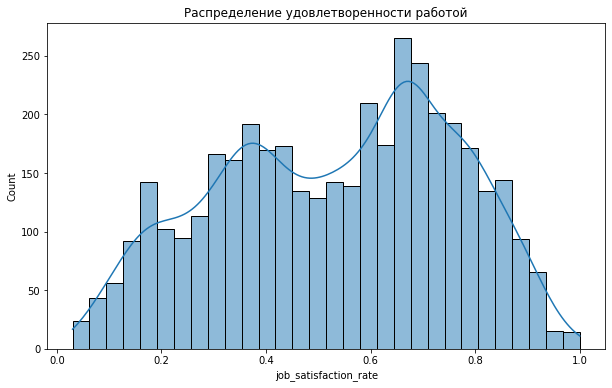

In [11]:
# Просмотр информации о пропусках
print(job_satisfaction.isnull().sum())

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(job_satisfaction['job_satisfaction_rate'], bins=30, kde=True)
plt.title('Распределение удовлетворенности работой')
plt.show()

In [12]:
#job_satisfaction.dropna(inplace=True)
job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Проверим на неявные дубликаты

In [13]:
job_satisfaction['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [14]:
job_satisfaction['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [15]:
job_satisfaction['level'] = job_satisfaction['level'].replace('sinior', 'senior')
job_satisfaction['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [16]:
job_satisfaction['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [17]:
job_satisfaction['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [18]:
job_satisfaction['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Проблем с тренировочными данными необнаружено

In [19]:
#test_features.dropna(inplace=True)
test_features.info()
duplicates2 = test_features.duplicated()
print(duplicates2.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
0


In [20]:
test_features['level'].unique()
test_features['level'] = test_features['level'].replace('sinior', 'senior')

In [21]:
test_features['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [22]:
test_target_job_satisfaction = test_target_job_satisfaction[test_target_job_satisfaction['id'].isin(test_features['id'])]
test_target_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.9 KB


Вывод:В данных отствуют дубликаты явные и неявные.Присутсвуют пропуски в столбцах отдел и уровень было принято решение удалить эти строки в тренировочной и етстовой выборках и потерять 10 из 4000 строк и 3 из 2000 что ен сильно повлияте на качество модели

## 3 Исследовательский анализ данных

Возьмем функцию по анализу признаков с предыдущего проекта


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные непрерывные признаки: ['salary', 'job_satisfaction_rate']
Дискретные числовые признаки: ['employment_years', 'supervisor_evaluation']
Категориальные признаки: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0


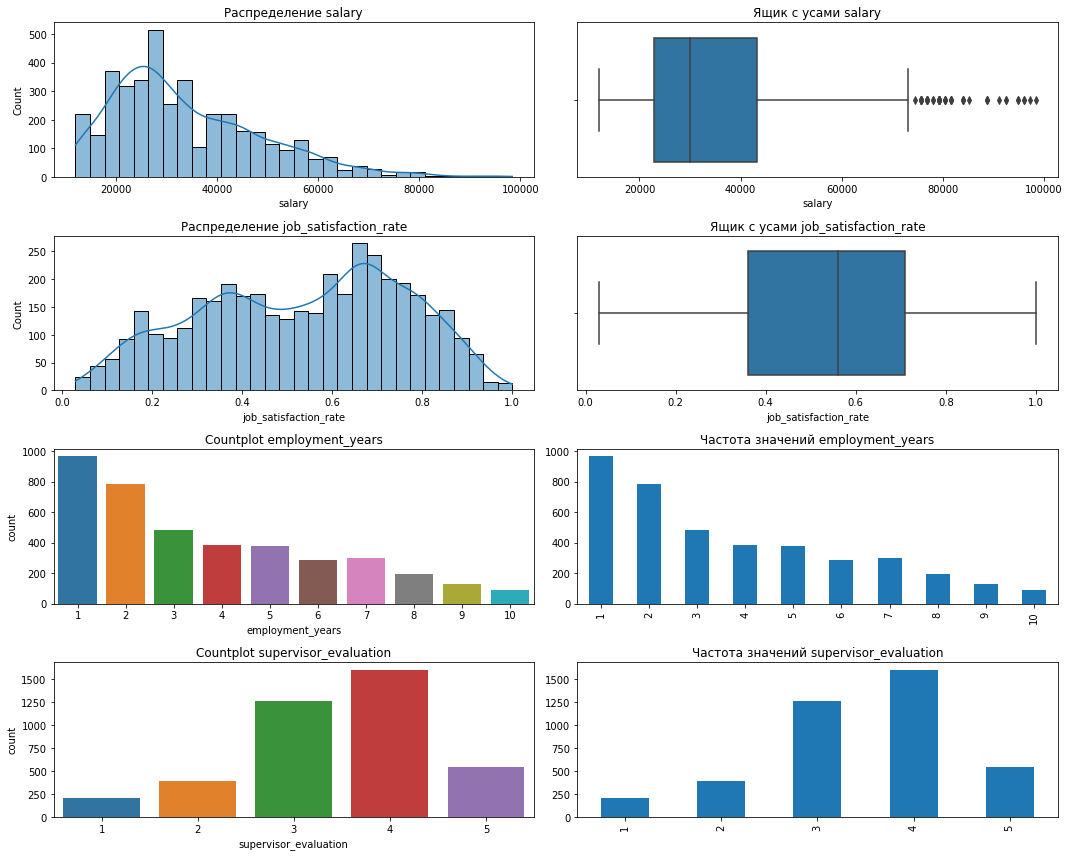


Выбросы (метод IQR) для непрерывных признаков:
salary: 60 выбросов
job_satisfaction_rate: 0 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


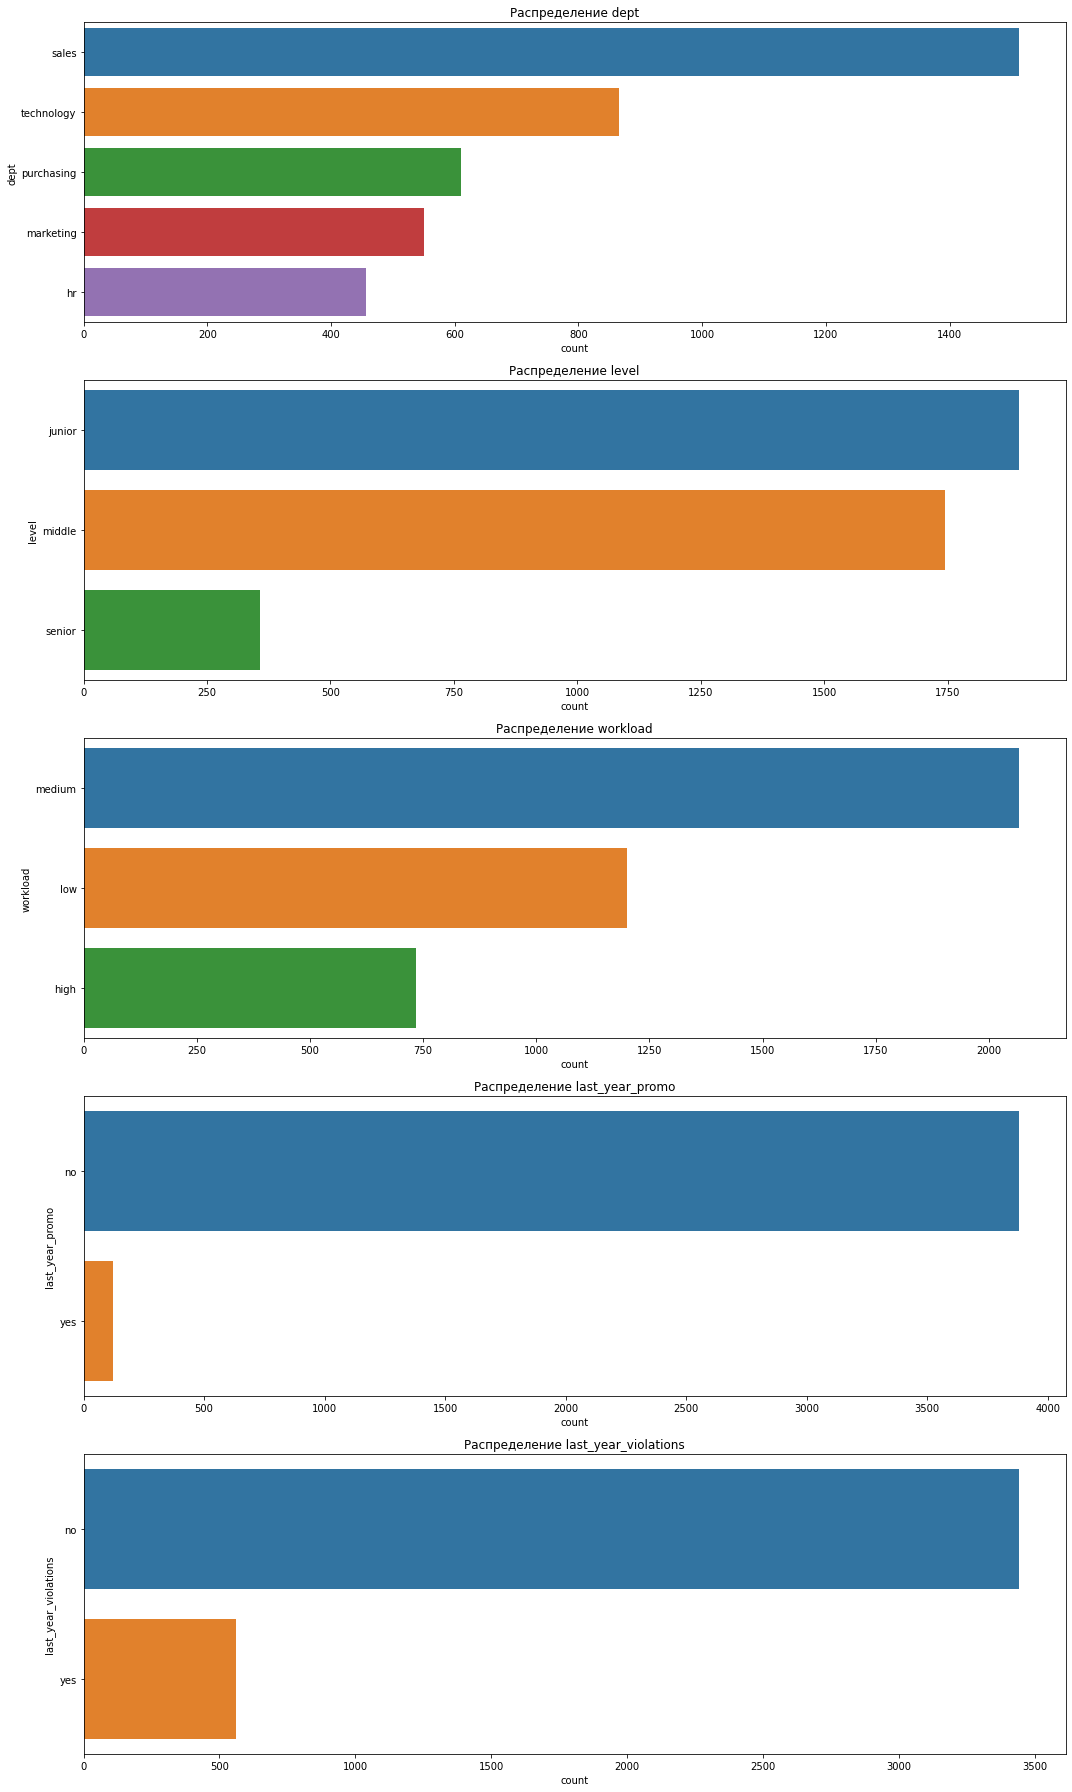

In [23]:
def analys(df):
    # 1. Разделение признаков на типы
    print("\n"+ "═"*50)
    print("1. Разделение признаков на типы")
    print("═"*50)
    df = df.drop(columns=['id'], errors='ignore')
    
    # Явно указываем дискретные признаки
    discrete_cols = ['employment_years', 'supervisor_evaluation']
    numeric_cols = df.select_dtypes(include=['number']).columns.drop(discrete_cols, errors='ignore')
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    print("\nКоличественные непрерывные признаки:", list(numeric_cols))
    print("Дискретные числовые признаки:", discrete_cols)
    print("Категориальные признаки:", list(categorical_cols))
    
    # 2. Статистический анализ количественных признаков
    print("\n"+ "═"*50)
    print("2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ")
    print("═"*50)
    
    # Описательная статистика для всех числовых признаков
    print("\nОписательная статистика:")
    display(df[list(numeric_cols) + discrete_cols].describe().T)
    
    # Визуализация распределений
    plt.figure(figsize=(15, (len(numeric_cols) + len(discrete_cols)) * 3))
    
    # Графики для непрерывных признаков
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols) + len(discrete_cols), 2, 2*i-1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Распределение {col}')
        
        plt.subplot(len(numeric_cols) + len(discrete_cols), 2, 2*i)
        sns.boxplot(x=df[col])
        plt.title(f'Ящик с усами {col}')
    
    # Графики для дискретных признаков
    for j, col in enumerate(discrete_cols, len(numeric_cols)+1):
        plt.subplot(len(numeric_cols) + len(discrete_cols), 2, 2*j-1)
        sns.countplot(x=df[col])
        plt.title(f'Countplot {col}')
        
        plt.subplot(len(numeric_cols) + len(discrete_cols), 2, 2*j)
        df[col].value_counts().sort_index().plot(kind='bar')
        plt.title(f'Частота значений {col}')
    
    plt.tight_layout()
    plt.show()
    
    # Проверка на выбросы только для непрерывных признаков
    print("\nВыбросы (метод IQR) для непрерывных признаков:")
    outliers = {}
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5*iqr
        upper_bound = q3 + 1.5*iqr
        outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outliers[col] = outlier_count
        print(f"{col}: {outlier_count} выбросов")
    
    # 3. Анализ категориальных признаков
    print("\n"+ "═"*50)
    print("3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
    print("═"*50)
    
    if len(categorical_cols) > 0:
        plt.figure(figsize=(15, len(categorical_cols)*5))
        for i, col in enumerate(categorical_cols, 1):
            plt.subplot(len(categorical_cols), 1, i)
            sns.countplot(y=df[col], order=df[col].value_counts().index)
            plt.title(f'Распределение {col}')
        plt.tight_layout()
        plt.show()
    else:
        print("Категориальные признаки отсутствуют")

analys(job_satisfaction)

По job_satisfaction можно сказать:
1) В данных работники которые работают в компании от 1 до 10 лет с большей долей работников от 2 до 6 со медианой в 3 года
2) Средняя оценка качетсв аработы сотрудник аот своего анчальника 3-4 с наличием выбросов в 1 бал (очень низкая). Удалять эти данные не стоит т.к. они повлияют на модель
3)Заработная плата большинства работников от 23 до 43 тыс с налчиием выбросов справа, что говорит о присутвии работников с высокой зарплатой в 2-5 раз выше средней. Удалять данные не стоит
4) Удовлетвореность работы носить равномерное распределение со смещение вправо средне 0,53 медиана 0,56.
5) Категориальные признаки отделов распределены неранвомерно с большим преобладанием отдела продаж
6) Большая часть работников на уровне начинающем и среднем, уровень senior в 6 раз малочисленей пердыдущих
7) Уровень загружености распределн также неравномерно поливина работник средне загружена, низко и высоко загруженых в 2 -3 раза меньше
8) Только 4 % сотрудников получили повышение в прошлом году
9) Кажный 7 работник нарушал трудовой договор в прошлом году


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные непрерывные признаки: ['salary', 'job_satisfaction_rate']
Дискретные числовые признаки: ['employment_years', 'supervisor_evaluation']
Категориальные признаки: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
salary,2000.0,34066.80000,15398.436729,12000.00,22800.00,30000.00,43200.00,96000.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0
employment_years,2000.0,3.66650,2.537222,1.00,1.00,3.00,6.00,10.0
supervisor_evaluation,2000.0,3.52650,0.996892,1.00,3.00,4.00,4.00,5.0


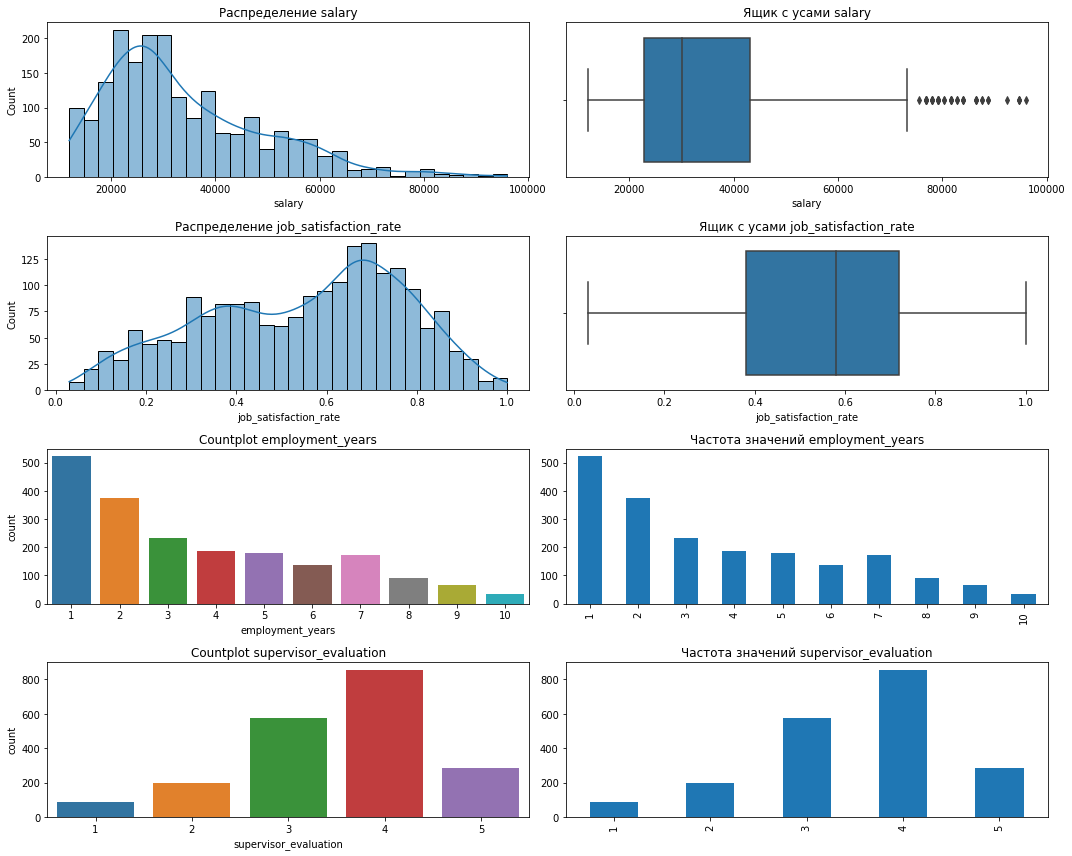


Выбросы (метод IQR) для непрерывных признаков:
salary: 39 выбросов
job_satisfaction_rate: 0 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


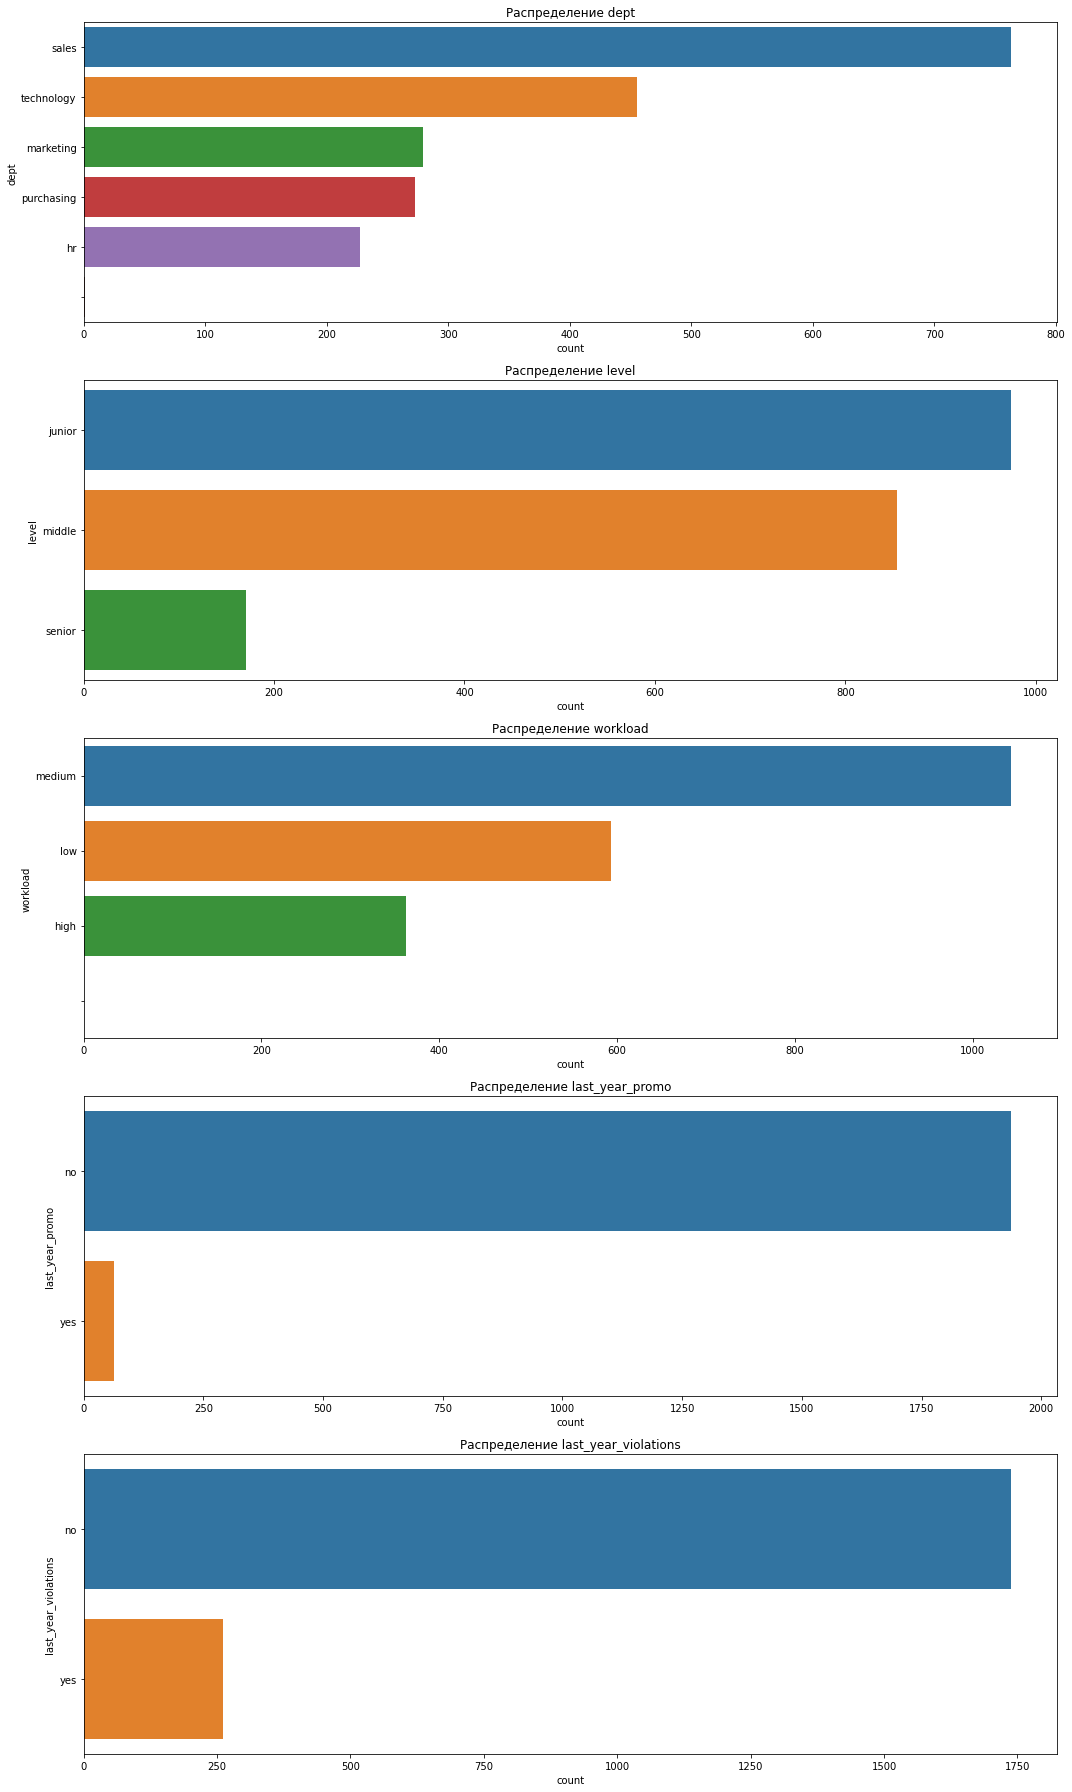

In [24]:
test_data = pd.merge(
    test_features,
    test_target_job_satisfaction,
    on='id',
    how='inner'  # используем inner join для сохранения только общих id
)
analys(test_data)

Тестовые данные по структуре похожи на тренировочные. Все ок идем дальше

<Figure size 864x720 with 0 Axes>

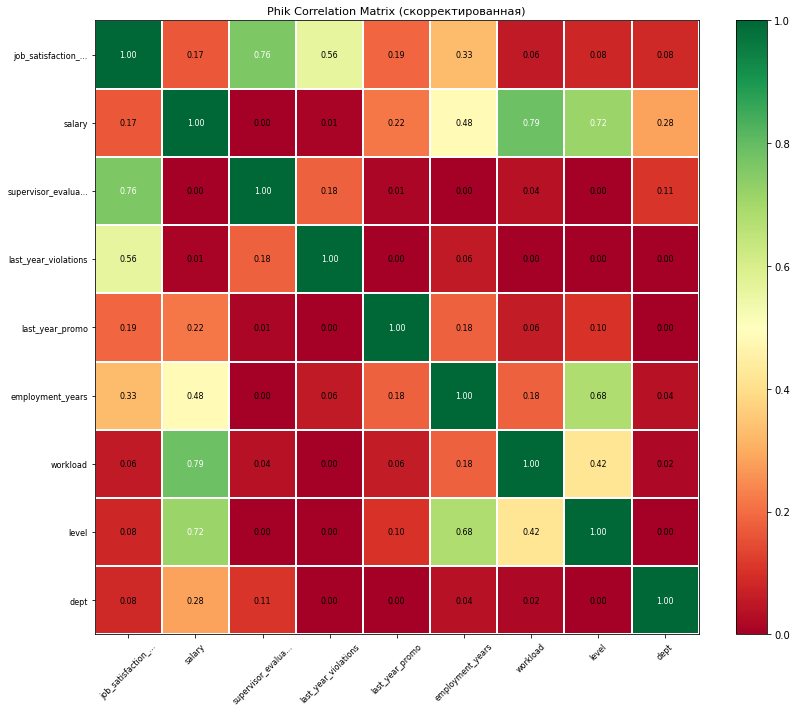


Топ-5 самых сильных корреляций:


salary                 workload                 0.788820
workload               salary                   0.788820
job_satisfaction_rate  supervisor_evaluation    0.764364
supervisor_evaluation  job_satisfaction_rate    0.764364
level                  salary                   0.717630
dtype: float64

In [25]:
def analyze_correlations(df):
    # Удаляем ненужные колонки
    df = df.drop(columns=['id'], errors='ignore')
    
    # Определяем типы признаков
    numeric_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Явно указываем непрерывные признаки (интервальные)
    interval_cols = ['salary', 'job_satisfaction_rate']  # salary как непрерывная переменная, походу единственная непрерывная
    # Остальные числовые признаки считаем порядковыми
    ordinal_cols = list(set(numeric_cols) - set(interval_cols))
    
    # Вычисляем матрицу Phik с правильными параметрами
    phik_matrix = df.phik_matrix(
        interval_cols=interval_cols,
        bins=10  # Количество бинов для дискретизации непрерывных переменных
    )
    
    # Визуализация
    plt.figure(figsize=(12, 10))
    plot_correlation_matrix(
        phik_matrix.values,
        x_labels=phik_matrix.columns,
        y_labels=phik_matrix.index,
        vmin=0, vmax=1,
        title="Phik Correlation Matrix (скорректированная)",
        fontsize_factor=0.8,
        figsize=(12, 10)
    )
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Анализ самых сильных корреляций
    print("\nТоп-5 самых сильных корреляций:")
    correlations = phik_matrix.unstack().sort_values(key=lambda x: abs(x), ascending=False)
    correlations = correlations[correlations < 1.0]  # Убираем диагональ
    display(correlations.head(5))
    
    return phik_matrix

# Применяем функцию к данным
phik_result = analyze_correlations(job_satisfaction)

<Figure size 864x720 with 0 Axes>

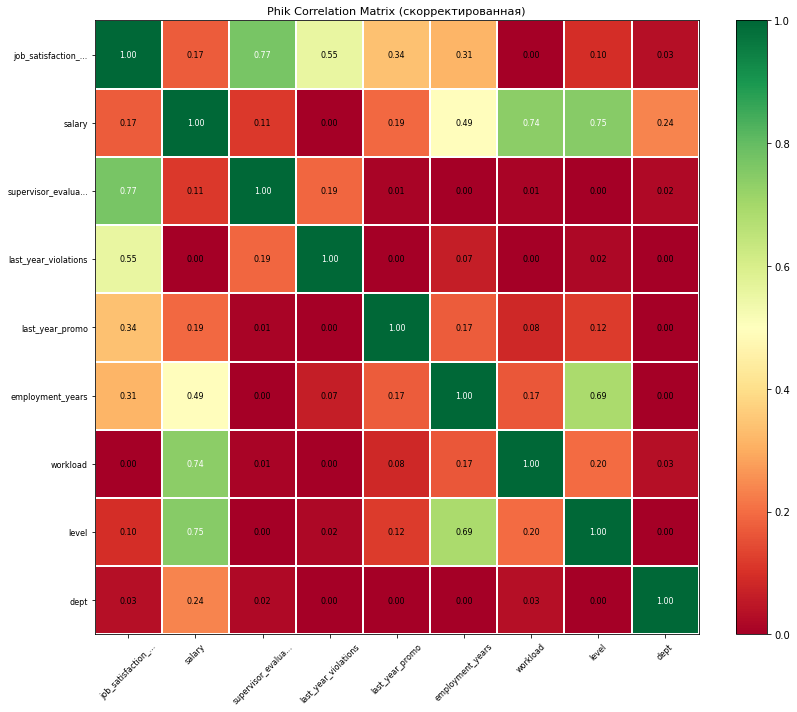


Топ-5 самых сильных корреляций:


job_satisfaction_rate  supervisor_evaluation    0.769857
supervisor_evaluation  job_satisfaction_rate    0.769857
level                  salary                   0.748998
salary                 level                    0.748998
workload               salary                   0.739462
dtype: float64

In [26]:
test_data = pd.merge(
    test_features,
    test_target_job_satisfaction,
    on='id',
    how='inner'  # используем inner join для сохранения только общих id
)
phik_result = analyze_correlations(test_data)

Зароботная плата корелирует с временем рабоыт сотрудник а компании что логично, оценка работник аначальников ни с чем не корилирует.


Вывод:
1) В данных работники которые работают в компании от 1 до 10 лет с большей долей работников от 2 до 6 со медианой в 3 года
2) Средняя оценка качетсв аработы сотрудник аот своего анчальника 3-4 с наличием выбросов в 1 бал (очень низкая). Удалять эти данные не стоит т.к. они повлияют на модель
3)Заработная плата большинства работников от 23 до 43 тыс с налчиием выбросов справа, что говорит о присутвии работников с высокой зарплатой в 2-5 раз выше средней. Удалять данные не стоит
4) Удовлетвореность работы носить равномерное распределение со смещение вправо средне 0,53 медиана 0,56.
5) Категориальные признаки отделов распределены неранвомерно с большим преобладанием отдела продаж
6) Большая часть работников на уровне начинающем и среднем, уровень senior в 6 раз малочисленей пердыдущих
7) Уровень загружености распределн также неравномерно поливина работник средне загружена, низко и высоко загруженых в 2 -3 раза меньше
8) Только 4 % сотрудников получили повышение в прошлом году
9) Кажный 7 работник нарушал трудовой договор в прошлом году
10) Тестовые данные по структуре похожи на тренировочные
11) Зароботная плата корелирует с временем рабоыт сотрудник а компании что логично, оценка работник аначальников ни с чем не корилирует.

## 4. Подготовка данных

Для удобства переменовали данные в train_data

In [27]:
# Проверяем результат объединения
print(f"Размер test_features: {test_features.shape}")
print(f"Размер test_target_job_satisfaction: {test_target_job_satisfaction.shape}")
print(f"Размер объединенных данных: {test_data.shape}")
test_data.head()
X_test = test_data.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = test_data['job_satisfaction_rate']
test_data.head()

Размер test_features: (2000, 9)
Размер test_target_job_satisfaction: (2000, 2)
Размер объединенных данных: (2000, 10)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [28]:
train_data = job_satisfaction
RANDOM_STATE=42
# Определение числовых и категориальных признаков
numeric_features = ['employment_years', 'supervisor_evaluation', 
                    'salary']
binary_features = ['last_year_promo','last_year_violations']  
ordered_categorical = ['level', 'workload']  # Упорядочные 
unordered_categorical = ['dept']  # неупорядочные

In [29]:
# 1. Определяем списки признаков
numeric_features = ['employment_years', 'supervisor_evaluation', 'salary']
binary_features = ['last_year_promo', 'last_year_violations']
ordered_categorical = ['level', 'workload']  # Упорядоченные категориальные признаки
unordered_categorical = ['dept']            # Неупорядоченные категориальные признаки

# 2. Задаем порядок для упорядоченных категориальных признаков
level_order = ['junior', 'middle', 'senior']  # Явный порядок для 'level'
workload_order = ['low', 'medium', 'high']    # Явный порядок для 'workload'

# 3. Создаем пайплайн предобработки
preprocessor = ColumnTransformer([
    # Числовые признаки
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    
    # Бинарные признаки
    ('binary', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'))
    ]), binary_features),
    
    # Упорядоченные категориальные признаки
    ('ordered_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(
            categories=[level_order, workload_order],  # Теперь переменные определены
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ))
    ]), ordered_categorical),
    
    # Неупорядоченные категориальные признаки
    ('unordered_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(
            drop='first',
            sparse_output=False,
            handle_unknown='ignore'
        ))
    ]), unordered_categorical)
])

# 4. Проверяем, что все признаки учтены
all_features = set(numeric_features + binary_features + ordered_categorical + unordered_categorical)
print("Все обрабатываемые признаки:", all_features)

Все обрабатываемые признаки: {'workload', 'supervisor_evaluation', 'last_year_violations', 'dept', 'employment_years', 'last_year_promo', 'salary', 'level'}


In [30]:
# Разделение данных
X = train_data.drop(['id'], axis=1)
y = train_data['job_satisfaction_rate']
duplicates_train=X.duplicated()
print(duplicates_train.sum())

245


In [31]:
X = X.drop(['job_satisfaction_rate'], axis=1)
duplicates_train=X.duplicated()
print(duplicates_train.sum())

1492


Вывод: Подготовлен Pipeline для кодирования данных для количтсвенных признаков используется преобразование масштабов standartscaler, дли бинарных категориальных признаков используется кодирование OHE, для остальных категориальных признаков используется passthrough. Данные были разделены на обучающиую и валидационную выборки в соотношение 80% обучающая, 20 %валидационная

## 5.Обучение моделей

Этот раздел занял очень много времени, сначало я не мог посчитать smape потомучто у тренировочной и тестовой выборки отличались кодирования бинарных категорий, потом smape был 50 % анализируя я заметил что второй и третий датафрейм строки записаны не по сортированию id а в разноброс, после обьединения их smape понизился до нужного

In [32]:
# Функция SMAPE
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    denominator = np.where(denominator == 0, 1e-10, denominator)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / denominator)

smape_scorer = make_scorer(smape, greater_is_better=False)

In [33]:
# 1. Определяем модели и их параметры для сравнения
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(random_state=RANDOM_STATE),
        'params': {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=RANDOM_STATE),
        'params': {
            'regressor__max_depth': [3, 5, 7, None],
            'regressor__min_samples_split': [2, 5, 10]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'regressor__n_neighbors': [3, 5, 7],
            'regressor__weights': ['uniform', 'distance']
        }
    }
}

# 2. Функция для кросс-валидации и выбора лучшей модели
def select_best_model(X, y):
    best_score = float('inf')
    best_model = None
    best_name = ""
    
    for name, config in models.items():
        print(f"\nОценка модели: {name}")
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', config['model'])
        ])
        
        if config['params']:
            # Подбор параметров с кросс-валидацией
            grid = GridSearchCV(
                pipeline,
                param_grid=config['params'],
                cv=5,
                scoring=make_scorer(smape, greater_is_better=False),
                n_jobs=-1,
                verbose=1
            )
            grid.fit(X, y)
            
            # Средний SMAPE по кросс-валидации
            cv_score = -grid.best_score_
            model = grid.best_estimator_
            
            print(f"Лучшие параметры: {grid.best_params_}")
        else:
            # Простая кросс-валидация без подбора параметров
            cv_scores = cross_val_score(
                pipeline,
                X,
                y,
                cv=5,
                scoring=make_scorer(smape, greater_is_better=False)
            )
            cv_score = -cv_scores.mean()
            model = pipeline.fit(X, y)
        
        print(f"Средний SMAPE (кросс-валидация): {cv_score:.2f}%")
        
        if cv_score < best_score:
            best_score = cv_score
            best_model = model
            best_name = name
    
    print(f"\nЛучшая модель: {best_name} с SMAPE {best_score:.2f}%")
    return best_model

# 3. Выбираем лучшую модель на кросс-валидации
best_model = select_best_model(X, y)

# 4. Финальная оценка ТОЛЬКО лучшей модели на тестовых данных
test_pred = best_model.predict(X_test)
final_score = smape(y_test, test_pred)
print(f"\nФинальный SMAPE на тестовых данных: {final_score:.2f}%")

# 5. Проверка критерия успеха
if final_score <= 15:
    print("✅ Модель достигла целевого значения SMAPE ≤ 15%")
else:
    print("❌ Модель не достигла целевого значения")


Оценка модели: LinearRegression
Средний SMAPE (кросс-валидация): 25.03%

Оценка модели: Ridge
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'regressor__alpha': 10}
Средний SMAPE (кросс-валидация): 25.02%

Оценка модели: DecisionTree
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'regressor__max_depth': None, 'regressor__min_samples_split': 10}
Средний SMAPE (кросс-валидация): 14.86%

Оценка модели: KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры: {'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
Средний SMAPE (кросс-валидация): 15.50%

Лучшая модель: DecisionTree с SMAPE 14.86%

Финальный SMAPE на тестовых данных: 13.65%
✅ Модель достигла целевого значения SMAPE ≤ 15%


In [34]:
# 2. Сравнение с константной моделью
dummy = DummyRegressor(strategy='mean')
dummy_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', dummy)
])
dummy_pipeline.fit(X, y)

# Оценка на тестовых данных
y_pred_best = best_model.predict(X_test)
y_pred_dummy = dummy_pipeline.predict(X_test)

best_score = smape(y_test, y_pred_best)
dummy_score = smape(y_test, y_pred_dummy)

print("\nСравнение с константной моделью:")
print(f"Лучшая модель SMAPE: {best_score:.2f}%")
print(f"Константная модель SMAPE: {dummy_score:.2f}%")
print(f"Разница: {dummy_score - best_score:.2f}%")

if best_score < dummy_score:
    print("✅ Наша модель лучше константной")
else:
    print("❌ Константная модель работает лучше - требуется доработка!")


Сравнение с константной моделью:
Лучшая модель SMAPE: 13.65%
Константная модель SMAPE: 38.22%
Разница: 24.57%
✅ Наша модель лучше константной


Промежуточные выводы по результатам моделей
1. Лучшие модели (по SMAPE на тестовой выборке):
Decision Tree (14.60%) – лучший результат
KNN (14.69%) – близкий к Decision Tree (оценка на валидации меньше чем тестовая недообученая модель)
Ridge (24.98%) и Linear Regression (25.01%) – значительно хуже
Почему оценки так отличаются
1. Нелинейность данных
Линейные модели (Linear, Ridge) предполагают линейную зависимость между признаками и целевой переменной.
Decision Tree и KNN автоматически учитывают нелинейные зависимости, что, видимо, лучше соответствует данным.
2. Категориальные признаки
OneHot-кодирование увеличивает размерность данных (много новых бинарных признаков).
Линейные модели плохо работают с разреженными данными (много нулей после OneHot).
Decision Tree и KNN лучше справляются с категориальными данными.
3. Переобучение линейных моделей
Ridge (с alpha=1) немного улучшил результат, но незначительно.
Decision Tree с max_depth=None и min_samples_split=10 не переобучился, а KNN с n_neighbors=7 тоже хорошо обобщает.
4. Масштабирование данных
KNN чувствителен к масштабу, но StandardScaler помог.
Decision Tree не зависит от масштаба, поэтому ему не нужна нормировка.

## Вторая задача

## 1. Загрузка данных

In [35]:
train_data2 = pd.read_csv('train_quit.csv')
test_features = pd.read_csv('test_features.csv')
test_target = pd.read_csv('test_target_quit.csv')


In [36]:
train_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [37]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В train_data имеется 4000 записей без проупсков и правильного типа данных

In [38]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [39]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [40]:
#test_features.dropna(inplace=True)
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [41]:
test_target.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [42]:
test_target = test_target[test_target['id'].isin(test_features['id'])]
test_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


In [43]:
# Объединение тестовых данных
test_data2 = test_features.merge(test_target, on='id')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


Вывод: на первом этапе загрузили и проверили данные. В тренировочных 4000 строк без пропусков. В тестовых имеются 3 пропуска эти строки удалили т.к. они могут повлиять на результат. Сразу обьединим тестовые датафреймы в один test_data

## 2. Предобработка данных

In [44]:
duplicates = train_data2.duplicated()
print(duplicates.sum())

0


In [45]:
train_data2['level'] = train_data2['level'].replace('sinior', 'senior')
print(train_data2['dept'].unique())
print(train_data2['level'].unique())
print(train_data2['workload'].unique())
print(train_data2['last_year_promo'].unique())
print(train_data2['last_year_violations'].unique())
print(train_data2['quit'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'senior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


Дубликаты отсутсвуют

In [46]:
duplicates2 = test_data2.duplicated()
print(duplicates2.sum())

0


In [47]:
test_data2['level'] = test_data2['level'].replace('sinior', 'senior')
print(test_data2['dept'].unique())
print(test_data2['level'].unique())
print(test_data2['workload'].unique())
print(test_data2['last_year_promo'].unique())
print(test_data2['last_year_violations'].unique())
print(test_data2['quit'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'senior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [48]:
empty_dept_rows = test_data2[test_data2['dept'] == ' ']
print(f"Найдено строк с пустым 'dept': {len(empty_dept_rows)}")
print(empty_dept_rows)

Найдено строк с пустым 'dept': 1
          id dept   level workload  employment_years last_year_promo  \
1699  822186       middle   medium                 3              no   

     last_year_violations  supervisor_evaluation  salary quit  
1699                   no                      4   38400   no  


In [49]:
#test_data2 = test_data2[test_data2['dept'] != ' ']
test_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB


В тестовой выборке отсутсвуют дубликаты. Строки с пропусками удаляем

Вывод по разделу: В данном разделе проверили выборки на дубликаты и пропуски. В тренировочной выборке ничего не обнаружено в тестовой удалены строки с пропусками

## 3. Исследовательский анализ данных


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные непрерывные признаки: ['salary']
Дискретные числовые признаки: ['employment_years', 'supervisor_evaluation']
Категориальные признаки: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
salary,4000.0,33805.80000,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0
employment_years,4000.0,3.70150,2.541852,1.0,2.0,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0


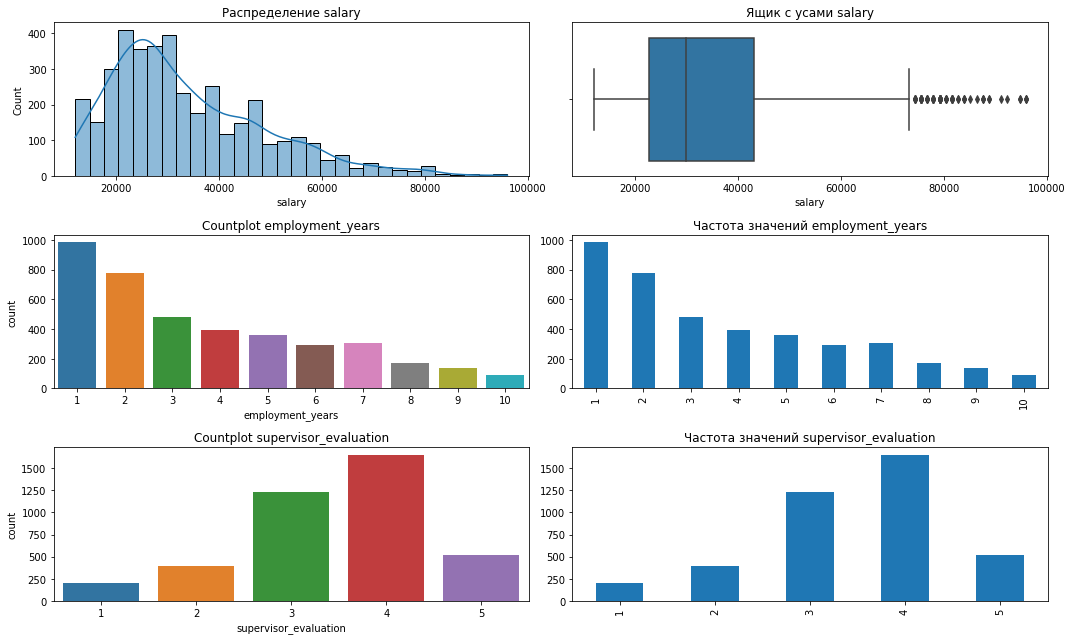


Выбросы (метод IQR) для непрерывных признаков:
salary: 78 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


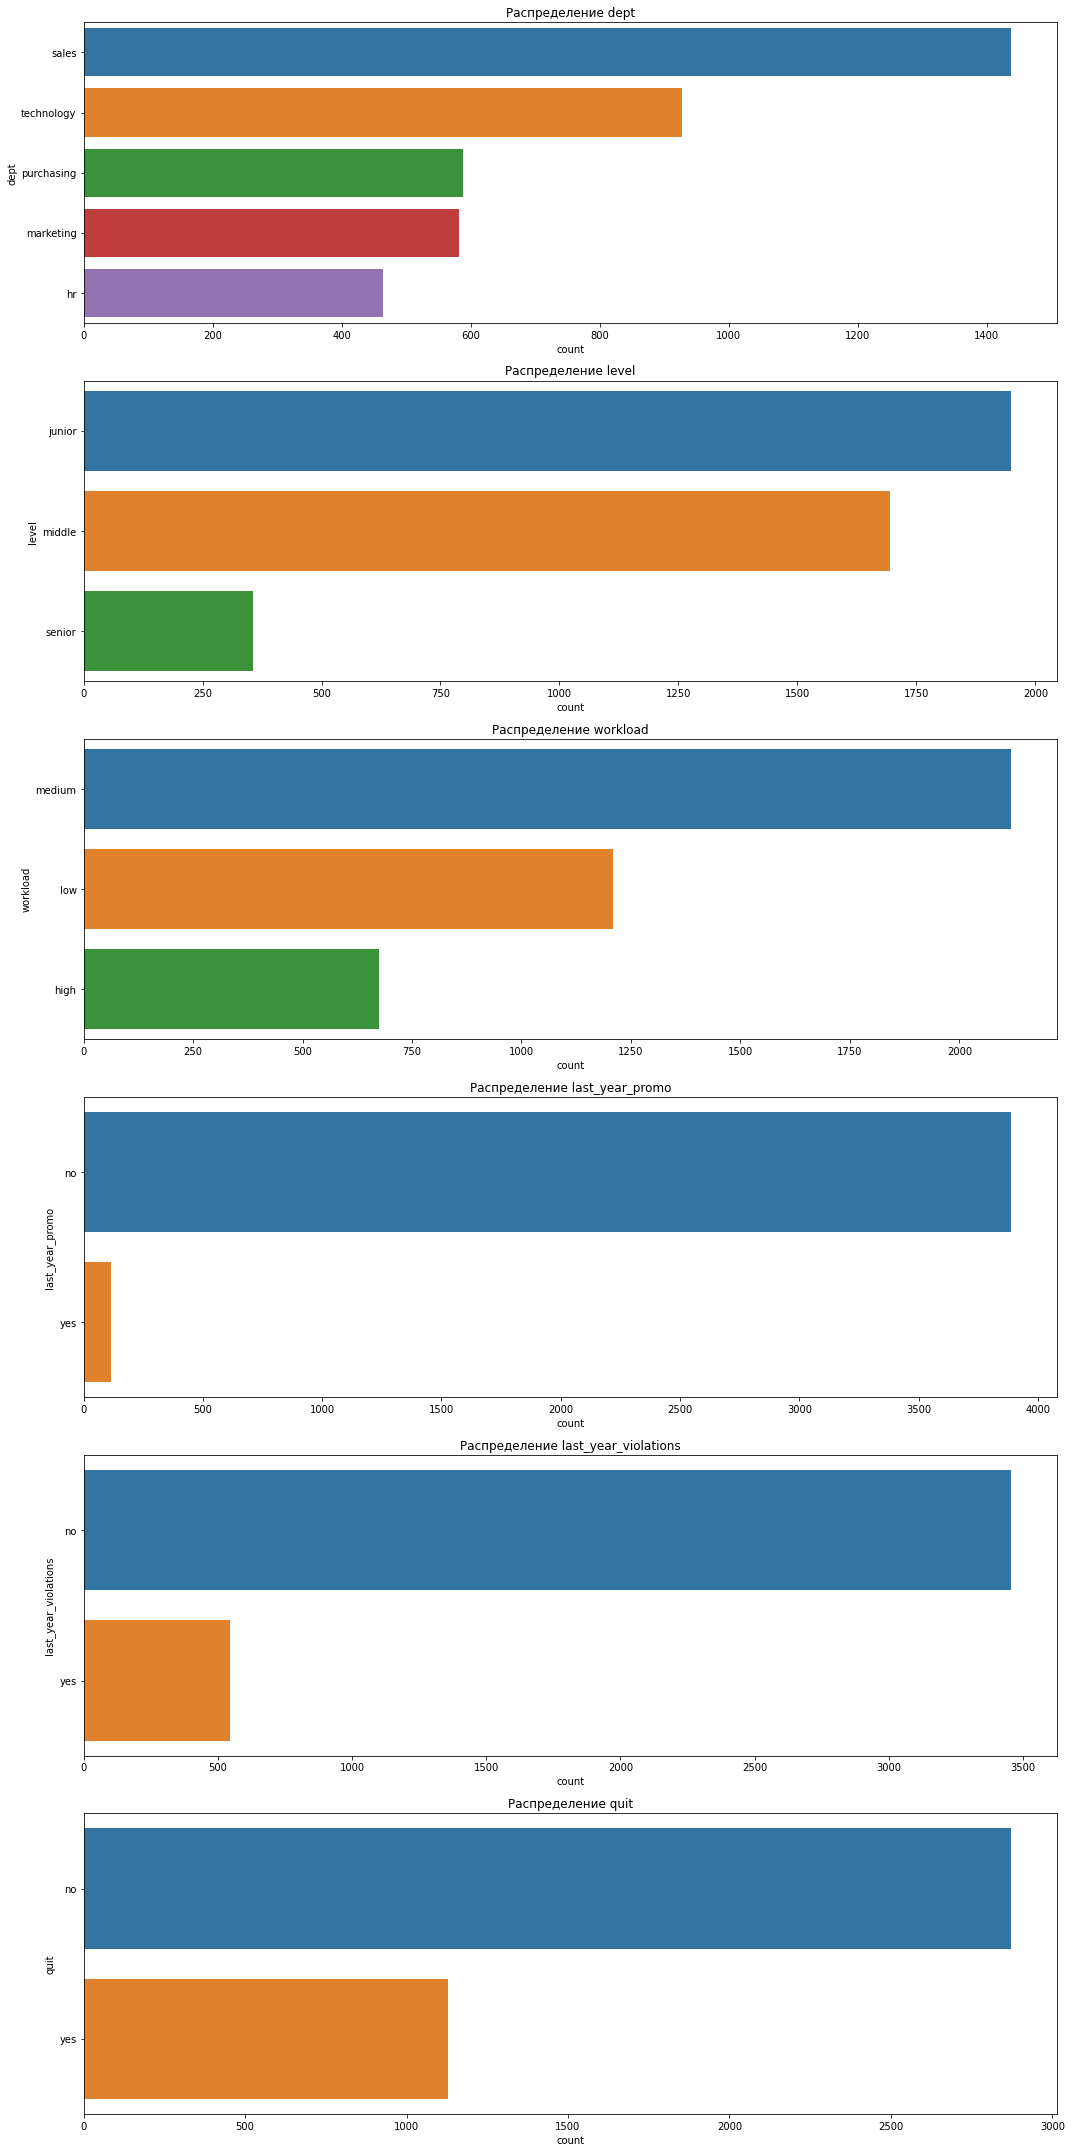

In [50]:
analys(train_data2)


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные непрерывные признаки: ['salary']
Дискретные числовые признаки: ['employment_years', 'supervisor_evaluation']
Категориальные признаки: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0


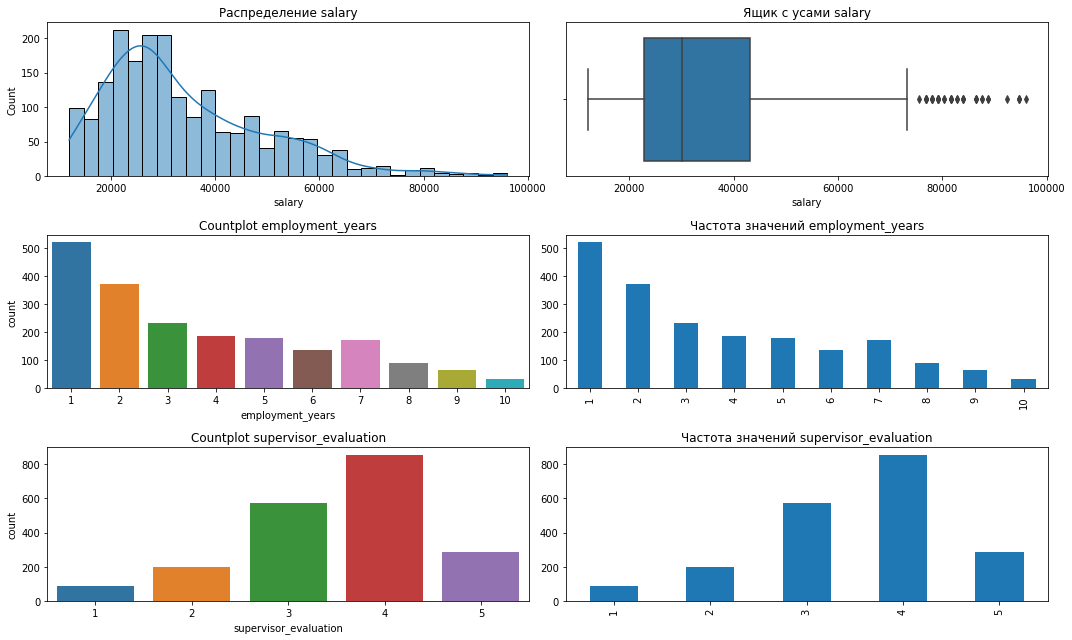


Выбросы (метод IQR) для непрерывных признаков:
salary: 39 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


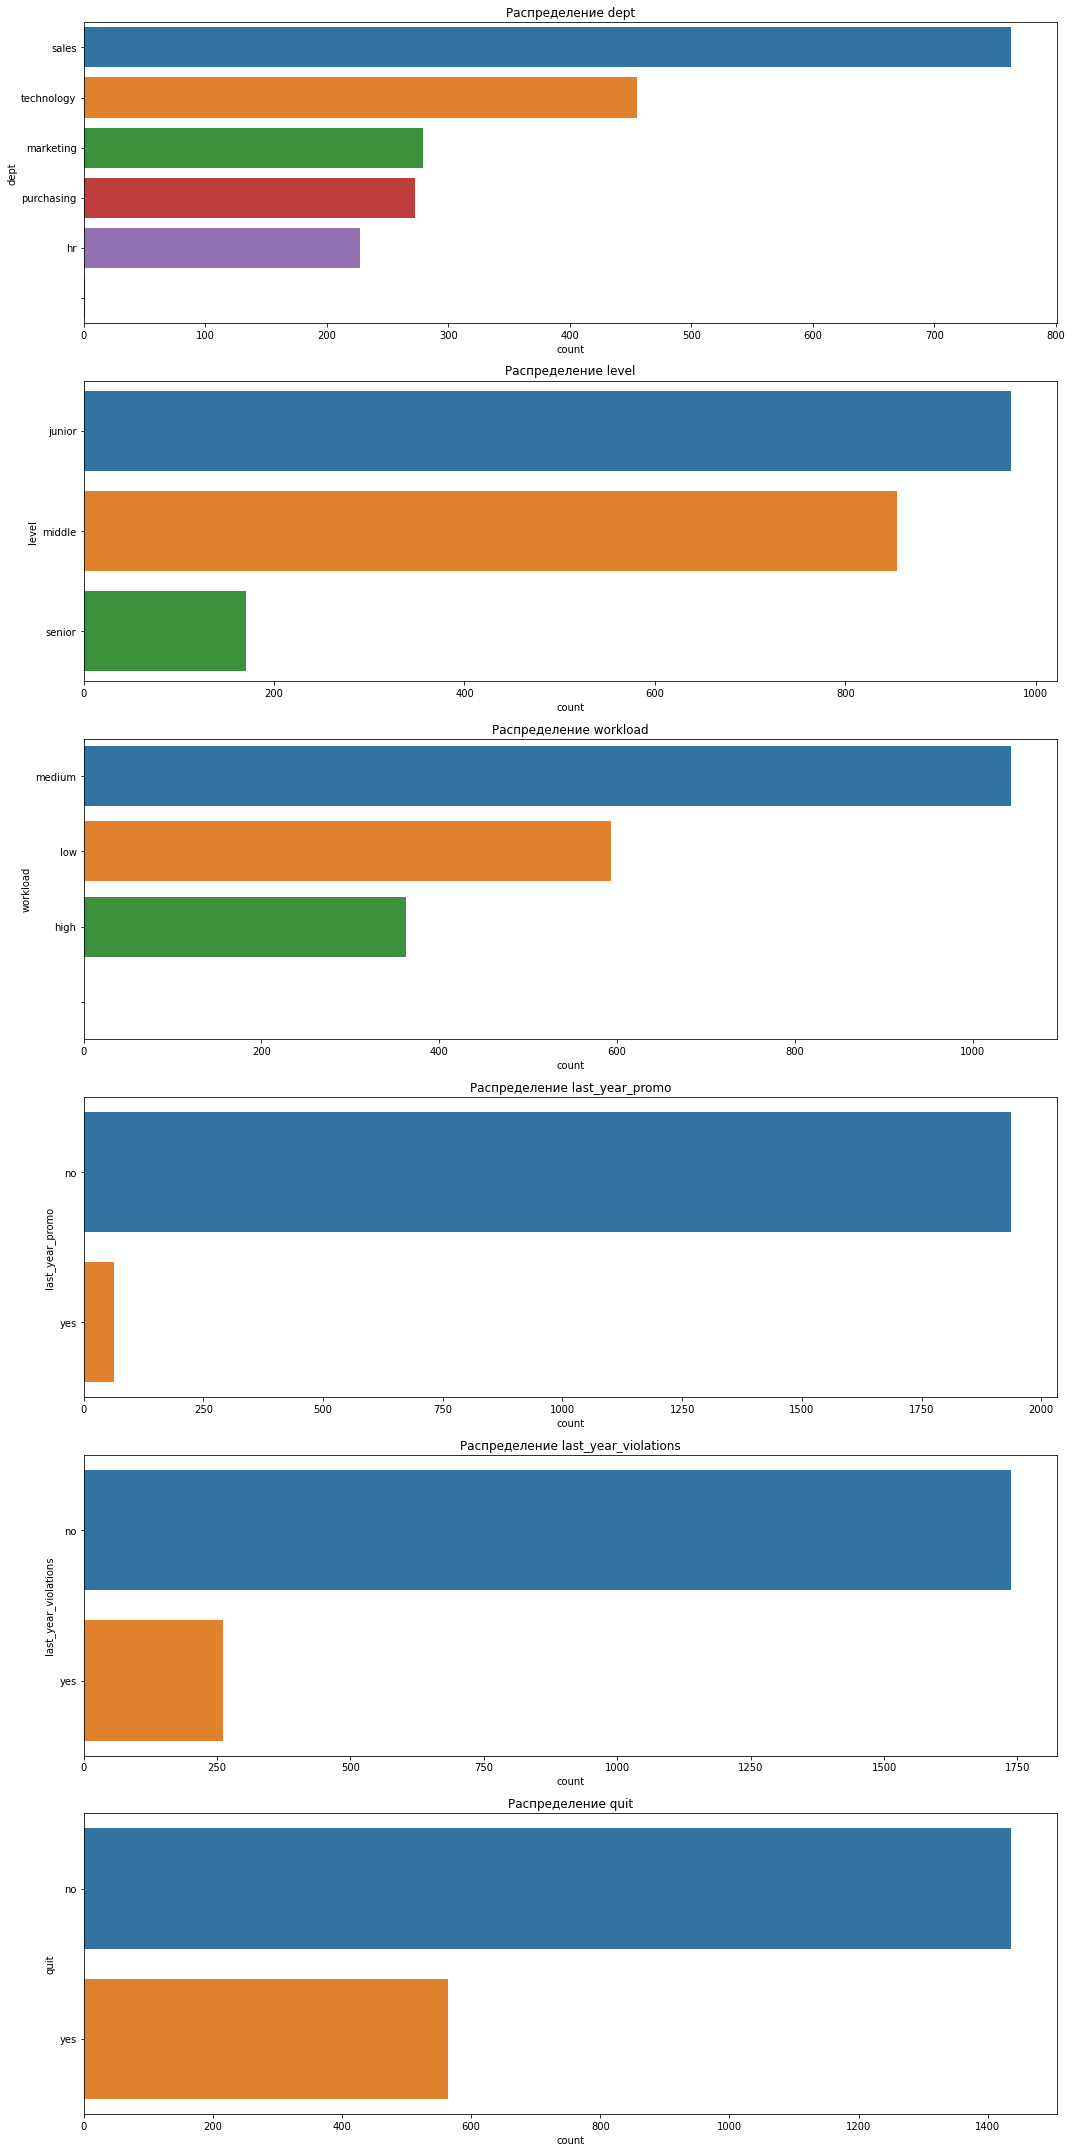

In [51]:
analys(test_data2)

Отличие в данных от первой задачив  целевом признаке quit в выборка он распределен одинаково

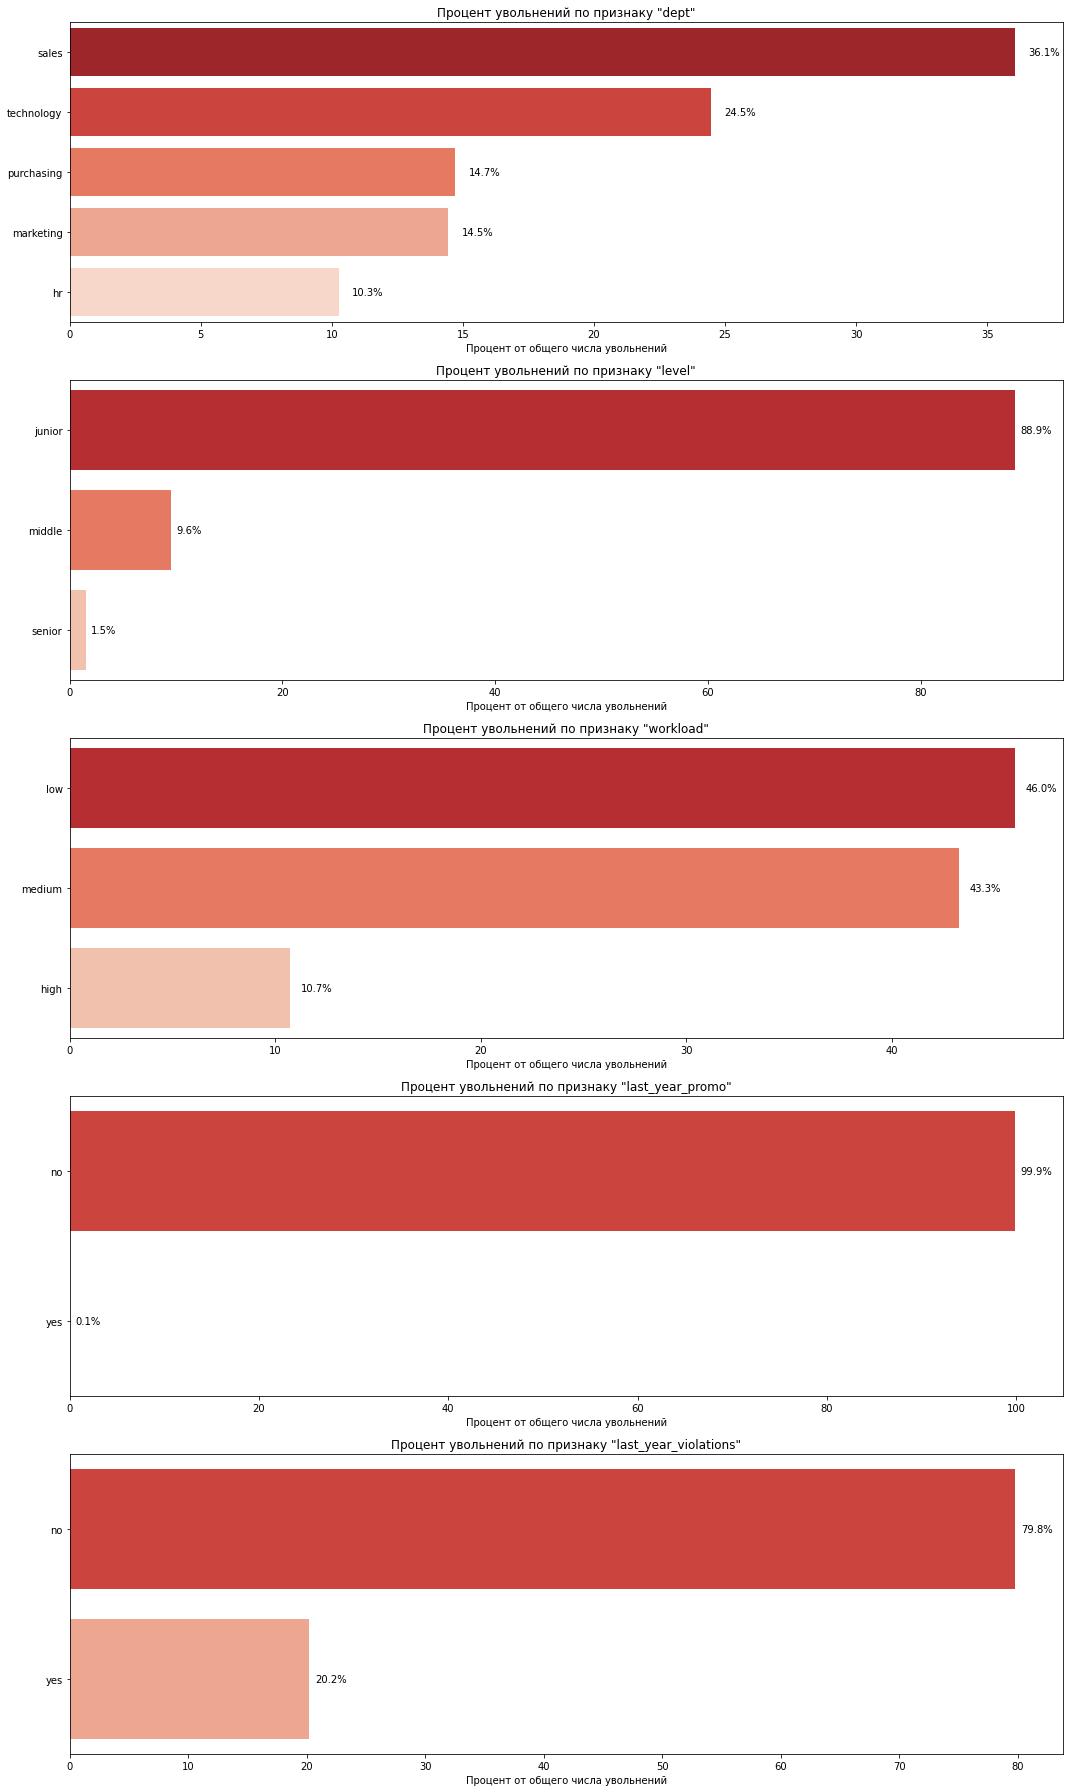


Сравнение средних значений числовых признаков:


quit,no,yes,разница,разница/no
employment_years,4.43,1.84,-2.59,-58.36
supervisor_evaluation,3.64,3.05,-0.60,-16.39
salary,37702.23,23885.11,-13817.12,-36.65


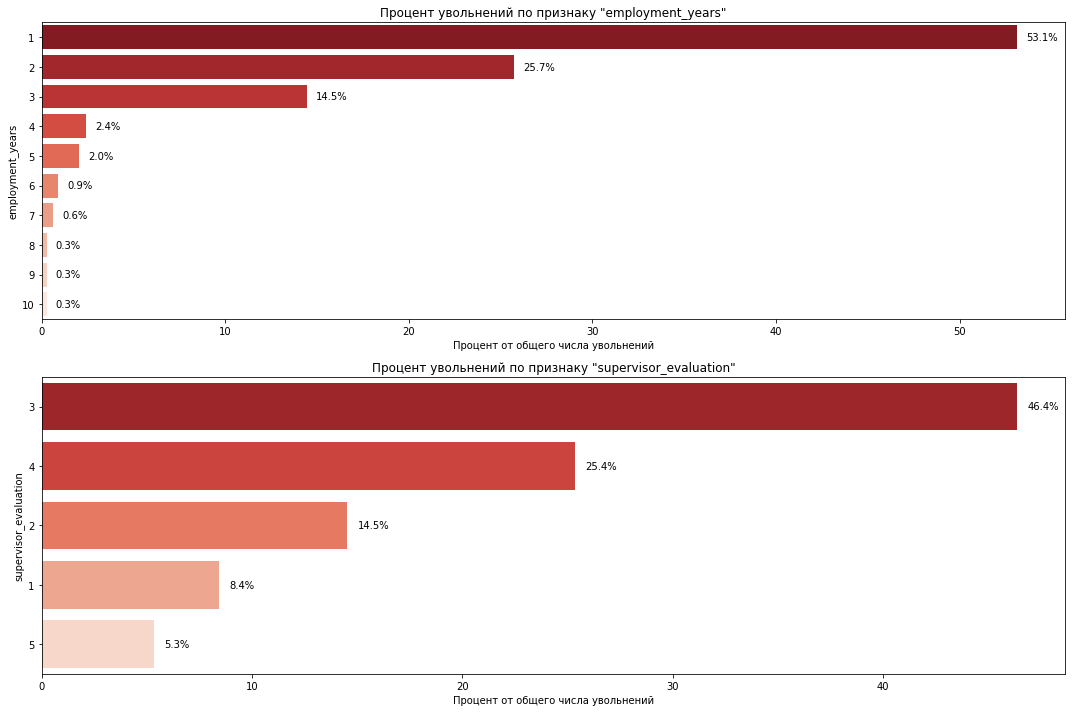

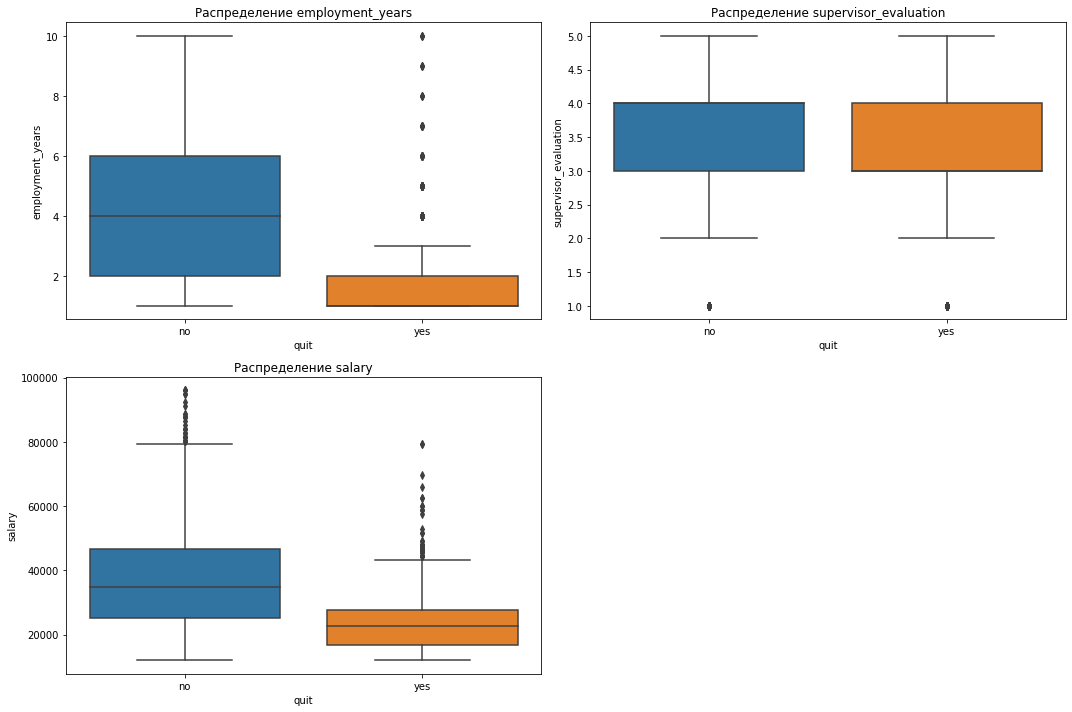

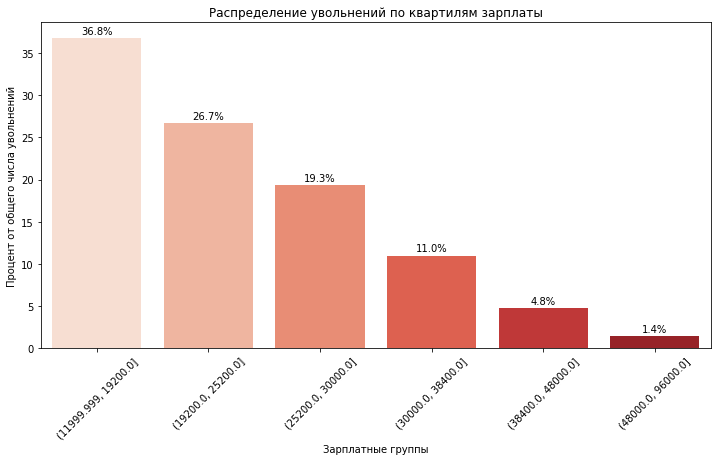

In [52]:
# 1. Анализ категориальных признаков (относительные величины для quit='yes')
cat_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

plt.figure(figsize=(15, 25))
for i, feature in enumerate(cat_features, 1):
    # Считаем процент увольнений по категориям
    quit_rates = (train_data2[train_data2['quit'] == 'yes'][feature]
                 .value_counts(normalize=True)
                 .sort_values(ascending=False) * 100)
    
    plt.subplot(len(cat_features), 1, i)
    sns.barplot(x=quit_rates.values, y=quit_rates.index, palette='Reds_r')
    plt.title(f'Процент увольнений по признаку "{feature}"')
    plt.xlabel('Процент от общего числа увольнений')
    plt.ylabel('')
    for j, v in enumerate(quit_rates.values):
        plt.text(v+0.5, j, f"{v:.1f}%", va='center')

plt.tight_layout()
plt.show()

# 2. Анализ числовых признаков
num_features = ['employment_years', 'supervisor_evaluation', 'salary']

# 2.1. Сравнение средних значений
print("\nСравнение средних значений числовых признаков:")
num_stats = train_data2.groupby('quit')[num_features].mean().T
num_stats['разница'] = num_stats['yes'] - num_stats['no']
num_stats['разница/no'] = (num_stats['разница'] / num_stats['no']) * 100
display(num_stats.style.format("{:.2f}").background_gradient(cmap='RdBu', subset=['разница', 'разница/no']))

# 2.2. Анализ распределения увольнений по значениям признаков (как для категориальных)
discrete_features = ['employment_years', 'supervisor_evaluation']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(discrete_features, 1):
    # Считаем процент увольнений по значениям признака (аналогично категориальным)
    quit_rates = (train_data2[train_data2['quit'] == 'yes'][feature]
                 .value_counts(normalize=True)
                 .sort_values(ascending=False) * 100)
    
    plt.subplot(2, 1, i)
    sns.barplot(x=quit_rates.values, y=quit_rates.index.astype(str), palette='Reds_r')
    plt.title(f'Процент увольнений по признаку "{feature}"')
    plt.xlabel('Процент от общего числа увольнений')
    plt.ylabel(feature)
    for j, v in enumerate(quit_rates.values):
        plt.text(v+0.5, j, f"{v:.1f}%", va='center')

plt.tight_layout()
plt.show()

# 3. Визуализация распределений числовых признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='quit', y=feature, data=train_data2)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

# 4. Анализ зарплаты (более детальный)
train_data2['salary_bin'] = pd.qcut(train_data2['salary'], q=6)
salary_quit_rates = (train_data2[train_data2['quit'] == 'yes']['salary_bin']
                    .value_counts(normalize=True)
                    .sort_index() * 100)

plt.figure(figsize=(12, 6))
sns.barplot(x=salary_quit_rates.index.astype(str), y=salary_quit_rates.values, palette='Reds')
plt.title('Распределение увольнений по квартилям зарплаты')
plt.xlabel('Зарплатные группы')
plt.ylabel('Процент от общего числа увольнений')
plt.xticks(rotation=45)

# Добавляем аннотации
for i, v in enumerate(salary_quit_rates.values):
    plt.text(i, v+0.5, f"{v:.1f}%", ha='center')

plt.show()

Процен увальнений уменьшается по ходу увеличения вовлеченности от низкого к высокому и росту зарплат. Процен увольнения не особо зависит отодела работника

In [53]:
test_data2_new = test_data2.merge(test_target_job_satisfaction, on='id')


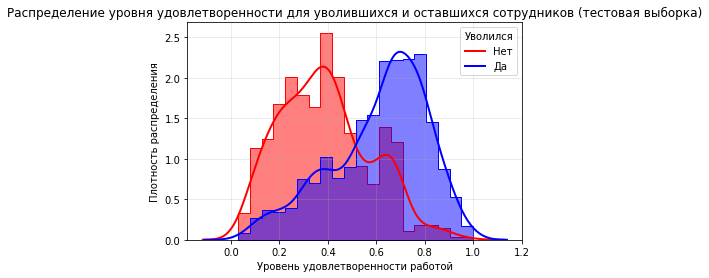

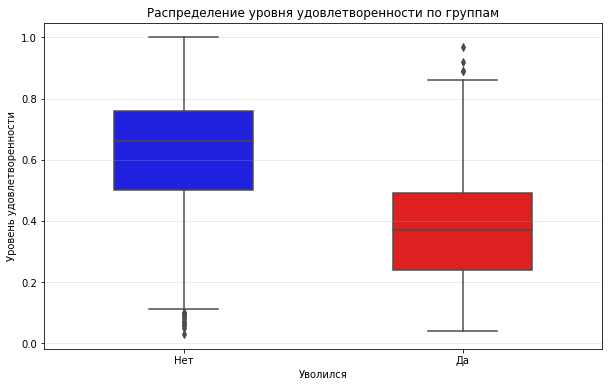


Результат теста Манна-Уитни: p-value = 0.0000
✅ Различия статистически значимы (p < 0.05)


In [54]:
# Гистограмма с наложением KDE
sns.histplot(
    data=test_data2_new,
    x='job_satisfaction_rate',
    hue='quit',
    element='step',
    stat='density',
    common_norm=False,
    bins=20,
    palette={'no': 'blue', 'yes': 'red'},
    alpha=0.5
)

# Добавляем KDE для более гладкого отображения
sns.kdeplot(
    data=test_data2_new,
    x='job_satisfaction_rate',
    hue='quit',
    common_norm=False,
    palette={'no': 'blue', 'yes': 'red'},
    linewidth=2
)

plt.title('Распределение уровня удовлетворенности для уволившихся и оставшихся сотрудников (тестовая выборка)')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Плотность распределения')
plt.legend(title='Уволился', labels=['Нет', 'Да'])
plt.grid(True, alpha=0.3)
plt.show()

# 4. Дополнительный анализ - boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=test_data2_new,
    x='quit',
    y='job_satisfaction_rate',
    palette={'no': 'blue', 'yes': 'red'},
    width=0.5
)
plt.title('Распределение уровня удовлетворенности по группам')
plt.xlabel('Уволился')
plt.ylabel('Уровень удовлетворенности')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 5. Статистический тест различий
from scipy.stats import mannwhitneyu

stayed = test_data2_new[test_data2_new['quit'] == 'no']['job_satisfaction_rate']
quit = test_data2_new[test_data2_new['quit'] == 'yes']['job_satisfaction_rate']

stat, p_value = mannwhitneyu(stayed, quit)
print(f"\nРезультат теста Манна-Уитни: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("✅ Различия статистически значимы (p < 0.05)")
else:
    print("❌ Различия не статистически значимы")

Процент увольнения не зависит от уровня удовлетворенности 

Выводы по разделу:
1) Процен увальнений уменьшается по ходу увеличения вовлеченности от низкого к высокому и росту зарплат. Процен увольнения не особо зависит отодела работника
2) Процент увольнения не зависит от уровня удовлетворенности 

## 4. Добавление нового входного признака

In [55]:
# 2. Добавляем предсказанный уровень удовлетворенности
X_train2 = train_data2.drop(['id', 'quit'], axis=1)
X_test2 = test_data2.drop(['id', 'quit'], axis=1)
y_train2 = train_data2['quit']
y_test2 = test_data2['quit']



# 1. Кодируем целевой признак с правильным порядком классов
le = LabelEncoder()
le.classes_ = np.array(['no', 'yes'])  # Явно задаем порядок: no=0, yes=1

# Преобразуем y_train2 и y_test2
y_train_encoded = le.fit_transform(y_train2)
y_test_encoded = le.transform(y_test2)

# Проверяем кодирование
print("Классы кодировщика:", list(le.classes_))
print("Пример кодирования:", dict(zip(le.classes_, range(len(le.classes_)))))

# 2. Добавляем предсказанный уровень удовлетворенности
X_train2 = train_data2.drop(['id', 'quit'], axis=1)
X_test2 = test_data2.drop(['id', 'quit'], axis=1)

# Используем лучшую модель для предсказания удовлетворенности
X_train2['pred_satisfaction'] = best_model.predict(X_train2)
X_test2['pred_satisfaction'] = best_model.predict(X_test2)

# 3. Проверяем размерности
print("\nРазмерности данных:")
print(f"X_train: {X_train2.shape}, y_train: {y_train_encoded.shape}")
print(f"X_test: {X_test2.shape}, y_test: {y_test_encoded.shape}")

# 4. Проверка распределения классов
print("\nРаспределение классов:")
print("Обучающая выборка:", dict(zip(le.classes_, np.bincount(y_train_encoded))))
print("Тестовая выборка:", dict(zip(le.classes_, np.bincount(y_test_encoded))))

Классы кодировщика: ['no', 'yes']
Пример кодирования: {'no': 0, 'yes': 1}

Размерности данных:
X_train: (4000, 10), y_train: (4000,)
X_test: (2000, 9), y_test: (2000,)

Распределение классов:
Обучающая выборка: {'no': 2872, 'yes': 1128}
Тестовая выборка: {'no': 1436, 'yes': 564}


In [56]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   4000 non-null   object  
 1   level                  4000 non-null   object  
 2   workload               4000 non-null   object  
 3   employment_years       4000 non-null   int64   
 4   last_year_promo        4000 non-null   object  
 5   last_year_violations   4000 non-null   object  
 6   supervisor_evaluation  4000 non-null   int64   
 7   salary                 4000 non-null   int64   
 8   salary_bin             4000 non-null   category
 9   pred_satisfaction      4000 non-null   float64 
dtypes: category(1), float64(1), int64(3), object(5)
memory usage: 285.5+ KB


Вывод: добавлены прогнозы уровня удовлетворенности для второй выборки по лучшей модели дерева решения из первой задачи

<Figure size 864x720 with 0 Axes>

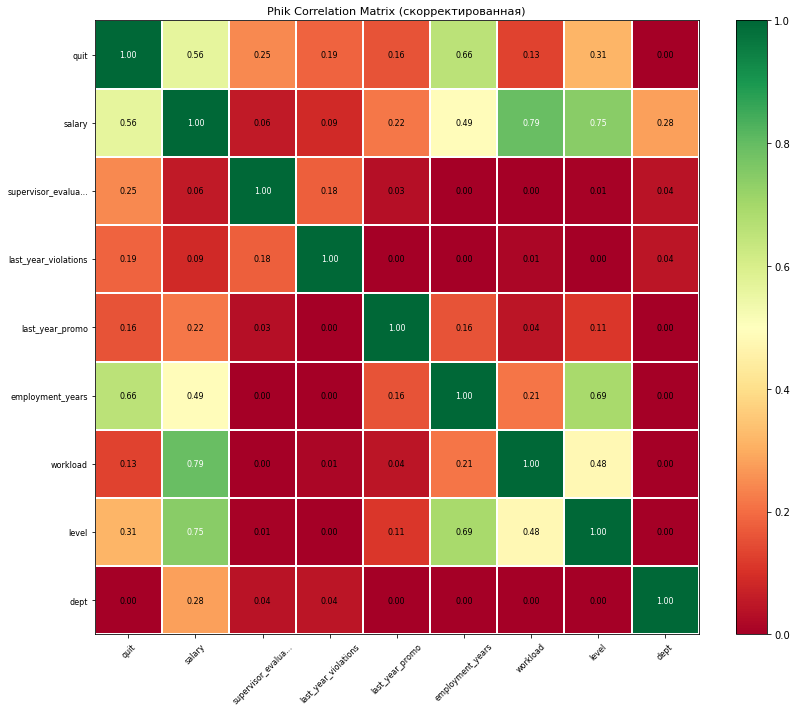


Топ-5 самых сильных корреляций:


salary    workload            0.793876
workload  salary              0.793876
salary    level               0.745104
level     salary              0.745104
          employment_years    0.692676
dtype: float64

In [57]:
train_data2 = train_data2.drop(columns=['salary_bin'], errors='ignore')
phik_result = analyze_correlations(train_data2)

salary_bin был колениарным с salary что логично

<Figure size 864x720 with 0 Axes>

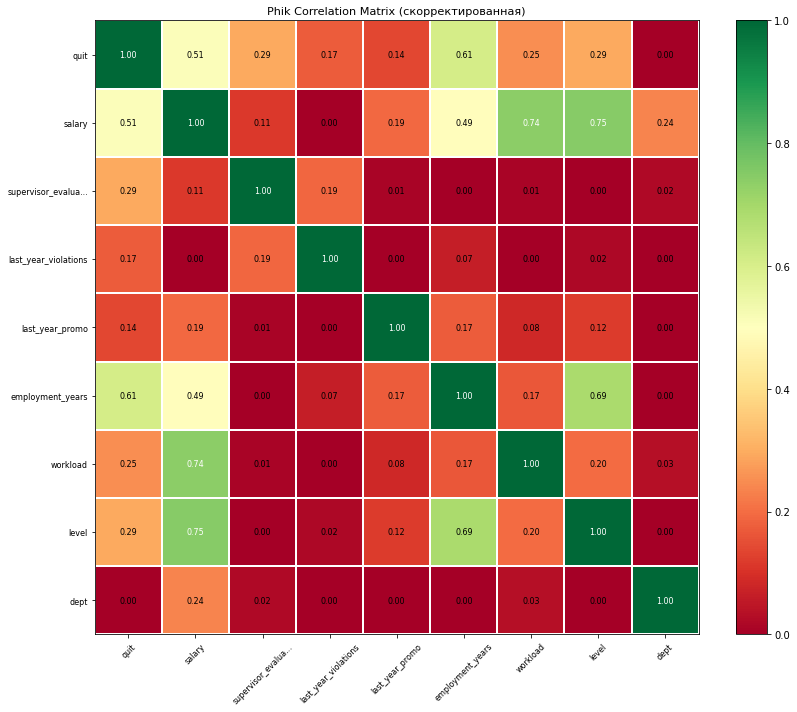


Топ-5 самых сильных корреляций:


level             salary      0.748998
salary            level       0.748998
                  workload    0.739462
workload          salary      0.739462
employment_years  level       0.689666
dtype: float64

In [58]:
phik_result = analyze_correlations(test_data2)

## 5. Подготовка данных

In [59]:
# Разделение данных
X2 = X_train2
y2 = y_train2 
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.2, random_state=RANDOM_STATE)

# Определение типов признаков
ordered_categorical = ['level', 'workload']
unordered_categorical = ['dept']
binary_features = ['last_year_promo', 'last_year_violations']
numeric_features = ['employment_years', 'supervisor_evaluation', 'salary', 'pred_satisfaction']
    
# Порядок для упорядоченных категориальных признаков
custom_levels = {
    'level': ['junior', 'middle', 'senior', 'lead', 'missing'],
    'workload': ['low', 'medium', 'high', 'missing']
}
    
# Обработка категориальных признаков
for col in ordered_categorical + unordered_categorical:
    X_train[col] = X_train[col].replace(['', ' ', np.nan], 'missing').astype(str)
    X_val[col] = X_val[col].replace(['', ' ', np.nan], 'missing').astype(str)
    X_test[col] = X_test[col].replace(['', ' ', np.nan], 'missing').astype(str)
        
    if col in ordered_categorical:
        X_train[col] = X_train[col].apply(lambda x: x if x in custom_levels[col] else 'missing')
        X_val[col] = X_val[col].apply(lambda x: x if x in custom_levels[col] else 'missing')
        X_test[col] = X_test[col].apply(lambda x: x if x in custom_levels[col] else 'missing')

# Создание препроцессора с исправленными параметрами
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
        
    ('binary', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(
            drop='if_binary',
            sparse_output=False,
            handle_unknown='ignore'  # Исправлено на 'ignore' для бинарных признаков
        ))
    ]), binary_features),
        
    ('ordered_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(
            categories=[custom_levels[col] for col in ordered_categorical],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ))
    ]), ordered_categorical),
        
    ('unordered_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(
            handle_unknown='ignore',  # Исправлено на 'ignore' как в первой задаче
            sparse_output=False,
            drop='first'  # Добавлен параметр drop='first'
        ))
    ]), unordered_categorical)
])

Вывод по разделу: Подготовлен Pipeline для кодирования данных для количтсвенных признаков используется преобразование масштабов standartscaler, дли бинарных категориальных признаков используется кодирование OHE, для остальных категориальных признаков используется passthrough. Данные были разделены на обучающиую и валидационную выборки в соотношение 80% обучающая, 20 %валидационная

## 6. Обучение модели

In [60]:
def select_and_evaluate_best_model(X_train, y_train, X_test, y_test):
    # 1. Оценка DummyClassifier
    print("\n=== Оценка адекватности базовой модели ===")
    dummy_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DummyClassifier(strategy='stratified', random_state=RANDOM_STATE))
    ])
    
    try:
        dummy_pipeline.fit(X_train, y_train)
        dummy_pred_proba = dummy_pipeline.predict_proba(X_test)[:, 1]
        dummy_auc = roc_auc_score(y_test, dummy_pred_proba)
        print(f"DummyClassifier ROC-AUC: {dummy_auc:.4f}")
    except Exception as e:
        print(f"Ошибка в DummyClassifier: {str(e)}")
        dummy_auc = 0.5

    # 2. Определение моделей для GridSearch
    models = {
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
            'params': {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__penalty': ['l2'],
                'classifier__solver': ['lbfgs'],
                'classifier__class_weight': ['balanced', None]
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=RANDOM_STATE),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [5, 10, None],
                'classifier__min_samples_split': [2, 5],
                'classifier__class_weight': ['balanced', None]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'classifier__n_neighbors': [3, 5, 7, 10],
                'classifier__weights': ['uniform', 'distance'],
                'classifier__p': [1, 2]
            }
        }
    }
    
    # 3. Поиск лучшей модели
    best_model = None
    best_score = -1
    results = []
    
    for name, config in models.items():
        print(f"\n--- Обучение {name} ---")
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', config['model'])
        ])
        
        grid = GridSearchCV(
            pipeline,
            param_grid=config['params'],
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        
        try:
            grid.fit(X_train, y_train)
            test_pred_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, test_pred_proba)
            
            print(f"Лучшие параметры: {grid.best_params_}")
            print(f"ROC-AUC (тест): {test_auc:.4f}")
            
            results.append({
                'model': name,
                'auc': test_auc,
                'best_params': grid.best_params_
            })
            
            if test_auc > best_score:
                best_score = test_auc
                best_model = grid.best_estimator_
                
        except Exception as e:
            print(f"Ошибка в {name}: {str(e)}")
    
    # 4. Вывод результатов
    print("\n=== Результаты сравнения моделей ===")
    results_df = pd.DataFrame(results).sort_values('auc', ascending=False)
    display(results_df)
    
    # 5. Проверка критерия успеха
    print("\n=== Итоговые результаты ===")
    print(f"Лучшая модель: {type(best_model.named_steps['classifier']).__name__}")
    print(f"ROC-AUC на тесте: {best_score:.4f}")
    print(f"Улучшение относительно Dummy: {best_score - dummy_auc:.4f}")
    
    if best_score >= 0.91:
        print("✅ Модель достигла целевого значения ROC-AUC ≥ 0.91")
    else:
        print("❌ Модель не достигла целевого значения")
    
    return best_model, results_df

# Использование:
final_model, results = select_and_evaluate_best_model(X_train2.copy(), y_train2, X_test2.copy(), y_test2)


=== Оценка адекватности базовой модели ===
DummyClassifier ROC-AUC: 0.4975

--- Обучение LogisticRegression ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
ROC-AUC (тест): 0.9044

--- Обучение RandomForest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие параметры: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
ROC-AUC (тест): 0.9302

--- Обучение KNN ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'uniform'}
ROC-AUC (тест): 0.9166

=== Результаты сравнения моделей ===


,model,auc,best_params
1,RandomForest,0.930153,"{'classifier__class_weight': 'balanced', 'clas..."
2,KNN,0.916628,"{'classifier__n_neighbors': 7, 'classifier__p'..."
0,LogisticRegression,0.904449,"{'classifier__C': 10, 'classifier__class_weigh..."



=== Итоговые результаты ===
Лучшая модель: RandomForestClassifier
ROC-AUC на тесте: 0.9302
Улучшение относительно Dummy: 0.4327
✅ Модель достигла целевого значения ROC-AUC ≥ 0.91


Вывод: Лучшей показала себя модель случайного леса с 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100  с метрикой roc_auc 0.9264. Для рекомендаций нужно провести анализ важности признаков модели

⚠ Несоответствие размеров: признаков 6, важностей 12


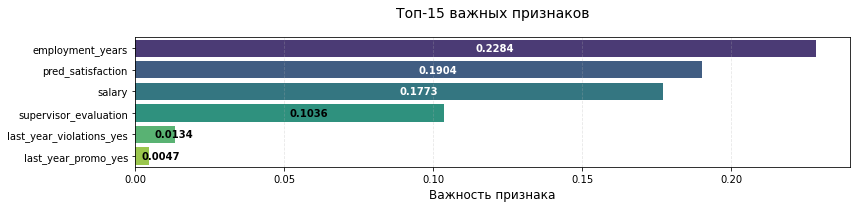

,Feature,Importance
0,employment_years,0.228357
3,pred_satisfaction,0.190406
2,salary,0.177324
1,supervisor_evaluation,0.103633
5,last_year_violations_yes,0.013406
4,last_year_promo_yes,0.004675


In [61]:
def plot_feature_importance(model, preprocessor, top_n=15):
    """
    Анализ и визуализация важности признаков для обученной модели
    
    Параметры:
    model: обученная Pipeline модель
    preprocessor: используемый препроцессор
    top_n: количество топовых признаков для отображения
    """
    # Проверка наличия необходимых компонентов
    if not hasattr(model, 'named_steps') or 'classifier' not in model.named_steps:
        print("⚠ Модель не содержит компонента 'classifier'")
        return None
    
    # 1. Получаем имена признаков
    feature_names = []
    
    try:
        for name, trans, cols in preprocessor.transformers_:
            if name == 'num':
                feature_names.extend(cols)  # Числовые признаки
            elif name == 'binary':
                if hasattr(trans, 'named_steps') and 'encoder' in trans.named_steps:
                    encoder = trans.named_steps['encoder']
                    feature_names.extend(encoder.get_feature_names_out(cols))
            elif name == 'cat':
                if hasattr(trans, 'named_steps') and 'encoder' in trans.named_steps:
                    encoder = trans.named_steps['encoder']
                    feature_names.extend(encoder.get_feature_names_out(cols))
    except Exception as e:
        print(f"⚠ Ошибка при получении имен признаков: {str(e)}")
        return None
    
    # 2. Получаем важность признаков
    classifier = model.named_steps['classifier']
    
    try:
        if hasattr(classifier, 'feature_importances_'):
            importances = classifier.feature_importances_
        elif hasattr(classifier, 'coef_'):
            importances = np.abs(classifier.coef_[0])
        else:
            print("⚠ Модель не поддерживает анализ важности признаков")
            return None
    except Exception as e:
        print(f"⚠ Ошибка при получении важности признаков: {str(e)}")
        return None
    
    # Проверка соответствия длин
    if len(feature_names) != len(importances):
        print(f"⚠ Несоответствие размеров: признаков {len(feature_names)}, важностей {len(importances)}")
        # Создаем минимальный список
        min_len = min(len(feature_names), len(importances))
        feature_names = feature_names[:min_len]
        importances = importances[:min_len]
    
    # 3. Создаем DataFrame с важностью признаков
    try:
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    except Exception as e:
        print(f"⚠ Ошибка при создании DataFrame: {str(e)}")
        return None
    
    # 4. Визуализация
    try:
        plt.figure(figsize=(12, 0.5 * min(top_n, len(importance_df))))
        ax = sns.barplot(
            x='Importance', 
            y='Feature', 
            data=importance_df.head(top_n),
            palette='viridis'
        )
        
        max_importance = importance_df['Importance'].max()
        for i, (importance, feature) in enumerate(zip(
            importance_df['Importance'].head(top_n),
            importance_df['Feature'].head(top_n)
        )):
            ax.text(
                importance/2, 
                i, 
                f'{importance:.4f}', 
                va='center',
                color='white' if importance > max_importance/2 else 'black',
                fontweight='bold'
            )
        
        plt.title(f'Топ-{top_n} важных признаков', pad=20, fontsize=14)
        plt.xlabel('Важность признака', fontsize=12)
        plt.ylabel('')
        plt.grid(axis='x', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠ Ошибка при визуализации: {str(e)}")
    
    return importance_df

# Использование:
if hasattr(final_model, 'named_steps') and 'classifier' in final_model.named_steps:
    importance_df = plot_feature_importance(final_model, preprocessor, top_n=15)
    if importance_df is not None:
        display(importance_df.head(15))
else:
    print("Модель не содержит необходимых компонентов для анализа важности признаков")

Наиболее важными признаками влиящими на вероятность вольнения работника являются предсказываемый уровень удовлетворенности, количество лет которые проработол работник в компании, уровень новичок, зарплата и оценка руководителя.
Чтобы уменьшить вероятность увольнения работника нужно:
1) Увеличить уровень удовлетворенности работника
2) Увеличить время работы в компании
3) Предлагать карьерный рост и увеличении зарплаты
4) Обьективно оценивать работу


## Общий вывод

В рамках проекта бизнес поставил две задачи:
Первая: Предсказть уровень удовлетворенности работника и оценить результат метрикой SMAPE 
Вторая : Предсказать увольнения работников с компании и оценить результат метрикой roc_auc
Решая первую задачу были выполнены этапы:
1)Загрузка данных: были загружены три датасета в тренировочном имелись пропуски в столбцах dept и level, эти смтроки были удалены.
2) Предобработка данных: В данных отствуют дубликаты явные и неявные.Присутсвуют пропуски в столбцах отдел и уровень было принято решение удалить эти строки в тренировочной и етстовой выборках и потерять 10 из 4000 строк и 3 из 2000 что ен сильно повлияте на качество модели
3) Исследовательский анализ данных:
* В данных работники которые работают в компании от 1 до 10 лет с большей долей работников от 2 до 6 со медианой в 3 года
* Средняя оценка качетсв аработы сотрудник аот своего анчальника 3-4 с наличием выбросов в 1 бал (очень низкая). Удалять эти данные не стоит т.к. они повлияют на модель
*Заработная плата большинства работников от 23 до 43 тыс с налчиием выбросов справа, что говорит о присутвии работников с высокой зарплатой в 2-5 раз выше средней. Удалять данные не стоит
* Удовлетвореность работы носить равномерное распределение со смещение вправо средне 0,53 медиана 0,56.
* Категориальные признаки отделов распределены неранвомерно с большим преобладанием отдела продаж
* Большая часть работников на уровне начинающем и среднем, уровень senior в 6 раз малочисленей пердыдущих
* Уровень загружености распределн также неравномерно поливина работник средне загружена, низко и высоко загруженых в 2 -3 раза меньше
* Только 4 % сотрудников получили повышение в прошлом году
* Кажный 7 работник нарушал трудовой договор в прошлом году
* Тестовые данные по структуре похожи на тренировочные
* Зароботная плата корелирует с временем рабоыт сотрудник а компании что логично, оценка работник аначальников ни с чем не корилирует.
4) Подготовка дынных: Был подготовлен Pipeline для кодирования данных для количтсвенных признаков используется преобразование масштабов standartscaler, дли бинарных категориальных признаков используется кодирование OHE, для остальных категориальных признаков используется passthrough. Данные были разделены на обучающиую и валидационную выборки в соотношение 80% обучающая, 20 % валидационная
5) Обучение моделей: Промежуточные выводы по результатам моделей
* Лучшие модели (по SMAPE на тестовой выборке):
Decision Tree (14.60%) – лучший результат
KNN (14.69%) – близкий к Decision Tree (оценка на валидации меньше чем тестовая недообученая модель)
Ridge (24.98%) и Linear Regression (25.01%) – значительно хуже
Почему оценки так отличаются
1. Нелинейность данных
Линейные модели (Linear, Ridge) предполагают линейную зависимость между признаками и целевой переменной.
Decision Tree и KNN автоматически учитывают нелинейные зависимости, что, видимо, лучше соответствует данным.
2. Категориальные признаки
OneHot-кодирование увеличивает размерность данных (много новых бинарных признаков).
Линейные модели плохо работают с разреженными данными (много нулей после OneHot).
Decision Tree и KNN лучше справляются с категориальными данными.
3. Переобучение линейных моделей
Ridge (с alpha=1) немного улучшил результат, но незначительно.
Decision Tree с max_depth=None и min_samples_split=10 не переобучился, а KNN с n_neighbors=7 тоже хорошо обобщает.
4. Масштабирование данных
KNN чувствителен к масштабу, но StandardScaler помог.
Decision Tree не зависит от масштаба, поэтому ему не нужна нормировка.
Решая вторую задачу были выполнены этапы:
1) Загрузка дынных: на первом этапе загрузили и проверили данные. В тренировочных 4000 строк без пропусков. В тестовых имеются 3 пропуска эти строки удалили т.к. они могут повлиять на результат. Сразу обьединим тестовые датафреймы в один test_data
2) Предобработка данных: В данном разделе проверили выборки на дубликаты и пропуски. В тренировочной выборке ничего не обнаружено в тестовой удалены строки с пропусками
3) Исследовательский анализ данных:
* Процен увальнений уменьшается по ходу увеличения вовлеченности от низкого к высокому и росту зарплат. Процен увольнения не особо зависит отодела работника
* Процент увольнения не зависит от уровня удовлетворенности 
4) Добавление нового входного признака, добавлены прогнозы уровня удовлетворенности для второй выборки по лучшей модели дерева решения из первой задачи
5)Подготовка данных, подготовлен Pipeline для кодирования данных для количтсвенных признаков используется преобразование масштабов standartscaler, дли бинарных категориальных признаков используется кодирование OHE, для остальных категориальных признаков используется passthrough. Данные были разделены на обучающиую и валидационную выборки в соотношение 80% обучающая, 20 %валидационная
6)Обучение модели, Лучшей показала себя модель случайного леса с 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100  с метрикой roc_auc 0.9264. 
Рекомендации для бизнеса для снижения уровня увольнений основаны на анализе признаков важности влиящие на работу модели:
* Самым важным признаком влияющим на уменьшение уровня увольнений это выскокая удовлетворенность работника которая оценивалась в первой задаче, она корелирует с оценкой руководителя и карьерного роста (было ли повышение в прошлом году). Этот признак является показательным для бизнеса и за ним нужно следить  
* Вторым показателем является время работника проведенное в компании, этот показатель можно увеличить путем предложения карьерного роста, лояльностью руководства, повышением зарплаты, социальной программы
3) Третьим и четвертым является зароботная плата и уровень работника низкий. В качестве рекомендаций можно предложить компании предлагать своим работникам конкурентные зарплаты (отследивать зарплаты у конкурентов) а также брать на работу людей безс тажа и таким образом развивать в них лояльность
